In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from scipy.signal import savgol_filter
from scipy.fft import fft, ifft

# 读取数据文件
data_file = '/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/004_UCR_Anomaly_DISTORTEDBIDMC1_2500_5400_5600.txt'
data = np.loadtxt(data_file)
data

array([-2785.9403, -3228.5676, -3528.9955, ..., -7733.413 , -7973.6916,
       -7602.0393])

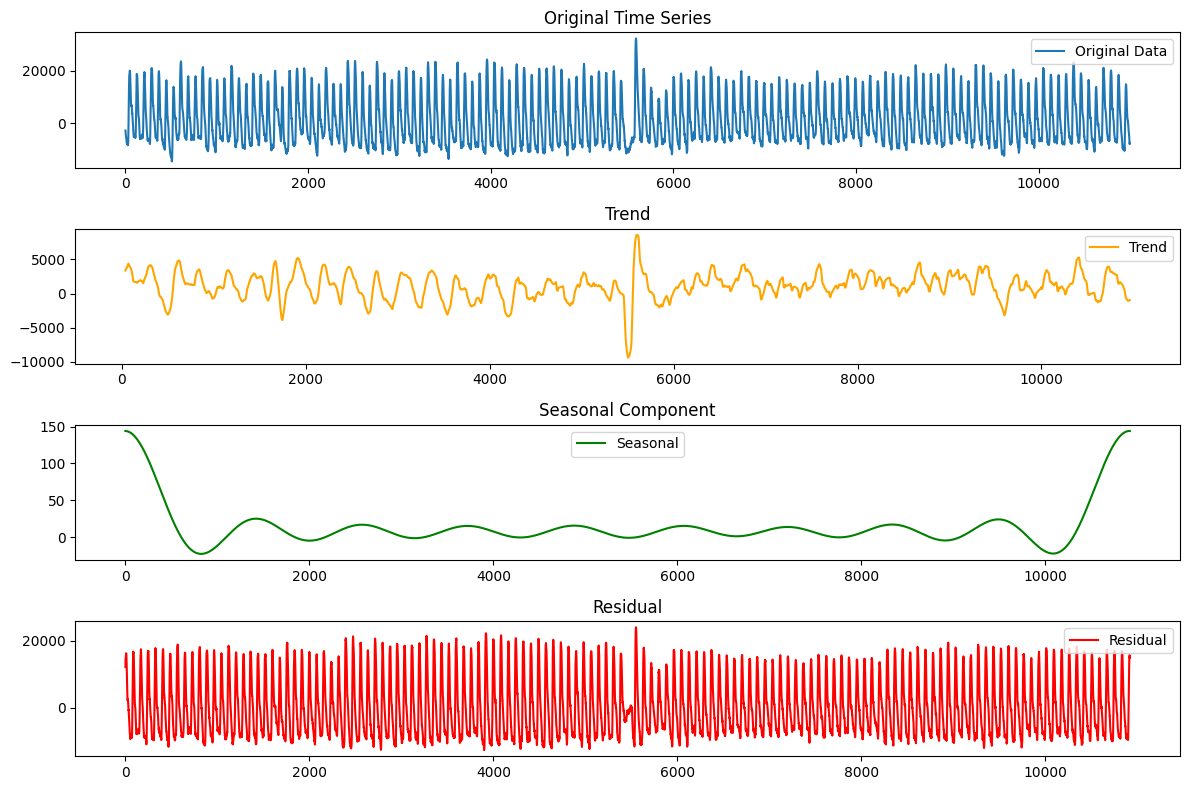

In [3]:
# 创建时间序列对象
ts = pd.Series(data)# Step 1: 提取趋势 - 使用简单移动平均线 (Moving Average)
def moving_average(series, window_size):
    return series.rolling(window=window_size, center=True).mean()
def extract_seasonal(residual, num_harmonics=10):
    # 对残差进行傅里叶变换
    fft_result = fft(residual)
    fft_filtered = np.copy(fft_result)
    
    # 保留前 num_harmonics 个傅里叶系数，其余设置为 0（低频保留，高频过滤）
    fft_filtered[num_harmonics:] = 0
    seasonal = np.real(ifft(fft_filtered))
    return seasonal
def detect_seasonality(data):
    # 创建时间序列对象
    ts = pd.Series(data)

    # 计算自相关函数
    autocorr = [ts.autocorr(lag=i) for i in range(1, len(ts)//2)]

    # 绘制自相关函数
    plt.figure(figsize=(10, 6))
    plt.plot(autocorr)
    plt.title('Autocorrelation')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

    # 识别自相关函数的第一个显著峰值作为周期长度
    from scipy.signal import find_peaks

    peaks, _ = find_peaks(autocorr, height=0)
    if len(peaks) > 0:
        period_length = peaks[0]  # 第一个峰值对应的滞后值
        print(f"周期长度为: {period_length}")
    else:
        print("未找到明显的周期。")
def plot_decomposition(data_file):
    data = np.loadtxt(data_file)
    ts = pd.Series(data)

    # 这里使用一个窗口大小为 101 的移动平均
    trend = moving_average(ts, window_size=80)

    # Step 2: 提取季节性 - 使用傅里叶变换

    # 计算残差部分
    residual_initial = ts - trend
    # 移除数据中的 NaN
    residual_initial = residual_initial.dropna()
    # 将 residual_initial 转换为 numpy 数组
    residual_initial = np.array(residual_initial)

    # 提取季节性成分
    seasonal = extract_seasonal(residual_initial, num_harmonics=10)

    # Step 3: 计算最终残差
    residual = residual_initial - seasonal

    # Step 4: 可视化结果
    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(ts, label='Original Data')
    plt.title('Original Time Series')
    plt.legend()

    plt.subplot(412)
    plt.plot(trend, label='Trend', color='orange')
    plt.title('Trend')
    plt.legend()

    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal', color='green')
    plt.title('Seasonal Component')
    plt.legend()

    plt.subplot(414)
    plt.plot(residual, label='Residual', color='red')
    plt.title('Residual')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 保存分解后的数据
    base_filename = data_file.split('/')[-1].split('.')[0]
    np.savetxt(f"/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/trend-{base_filename}.txt", trend.dropna().values)
    np.savetxt(f"/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/seasonal-{base_filename}.txt", seasonal)
    np.savetxt(f"/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/residual-{base_filename}.txt", residual)
plot_decomposition(data_file)

使用的 window_size: 80


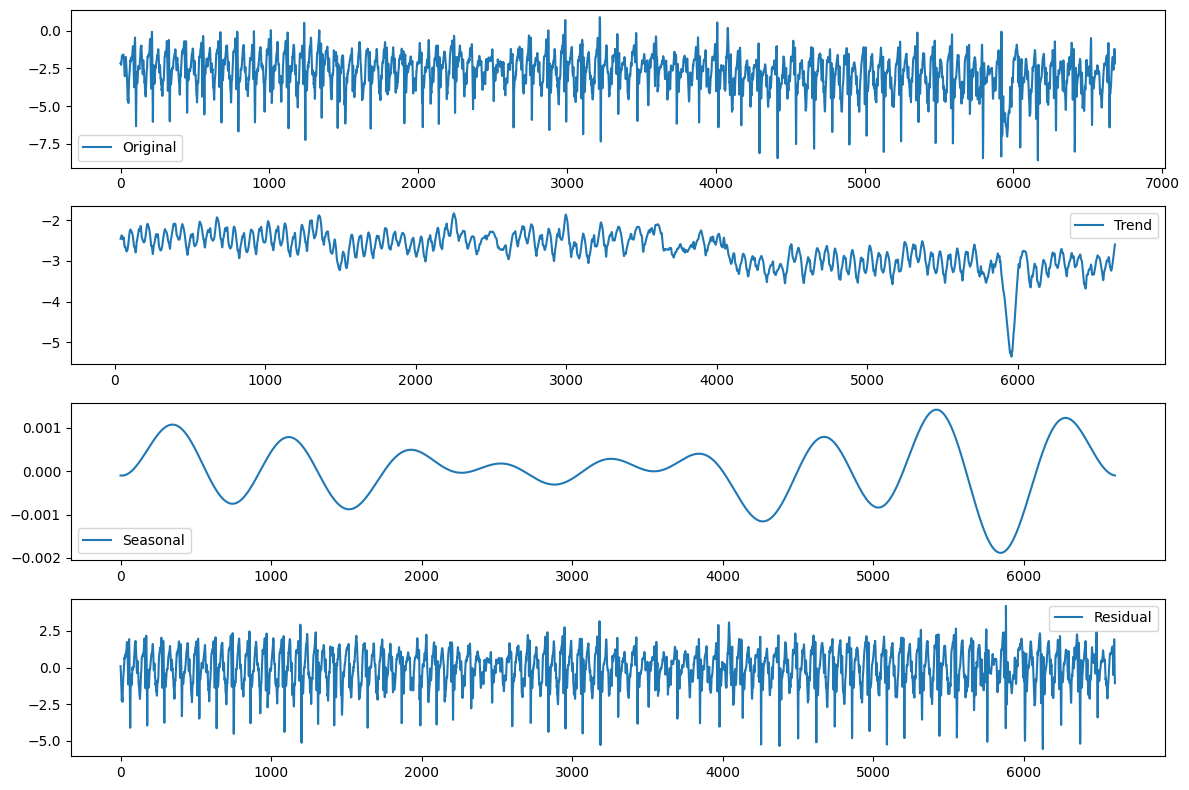

In [6]:
data_file = '/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/054_UCR_Anomaly_DISTORTEDWalkingAceleration5_2700_5920_5979.txt'
# 基于自相关函数确定 window_size
def estimate_window_size(ts):
    autocorr = pd.Series(ts).autocorr(lag=1)  # 计算第一个滞后期的自相关
    if autocorr < 0.5:
        return 20  # 如果自相关较低，使用较小的窗口
    else:
        return 80  # 如果自相关较高，使用较大的窗口

# 更新 plot_decomposition 函数
def plot_decomposition(data_file):
    data = np.loadtxt(data_file)
    ts = pd.Series(data)

    # 动态计算窗口大小
    window_size = estimate_window_size(ts)
    print(f"使用的 window_size: {window_size}")

    # 提取趋势部分
    trend = moving_average(ts, window_size)

    # 其他步骤保持不变
    residual_initial = ts - trend
    residual_initial = residual_initial.dropna()
    residual_initial = np.array(residual_initial)
    seasonal = extract_seasonal(residual_initial, num_harmonics=10)
    residual = residual_initial - seasonal

    # 绘制分解结果
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend()
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend()
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend()
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # 保存分解后的数据
    base_filename = data_file.split('/')[-1].split('.')[0]
    np.savetxt(f"/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/trend-{base_filename}.txt", trend.dropna().values)
    np.savetxt(f"/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/seasonal-{base_filename}.txt", seasonal)
    np.savetxt(f"/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/residual-{base_filename}.txt", residual)
plot_decomposition(data_file)

使用的 window_size: 80


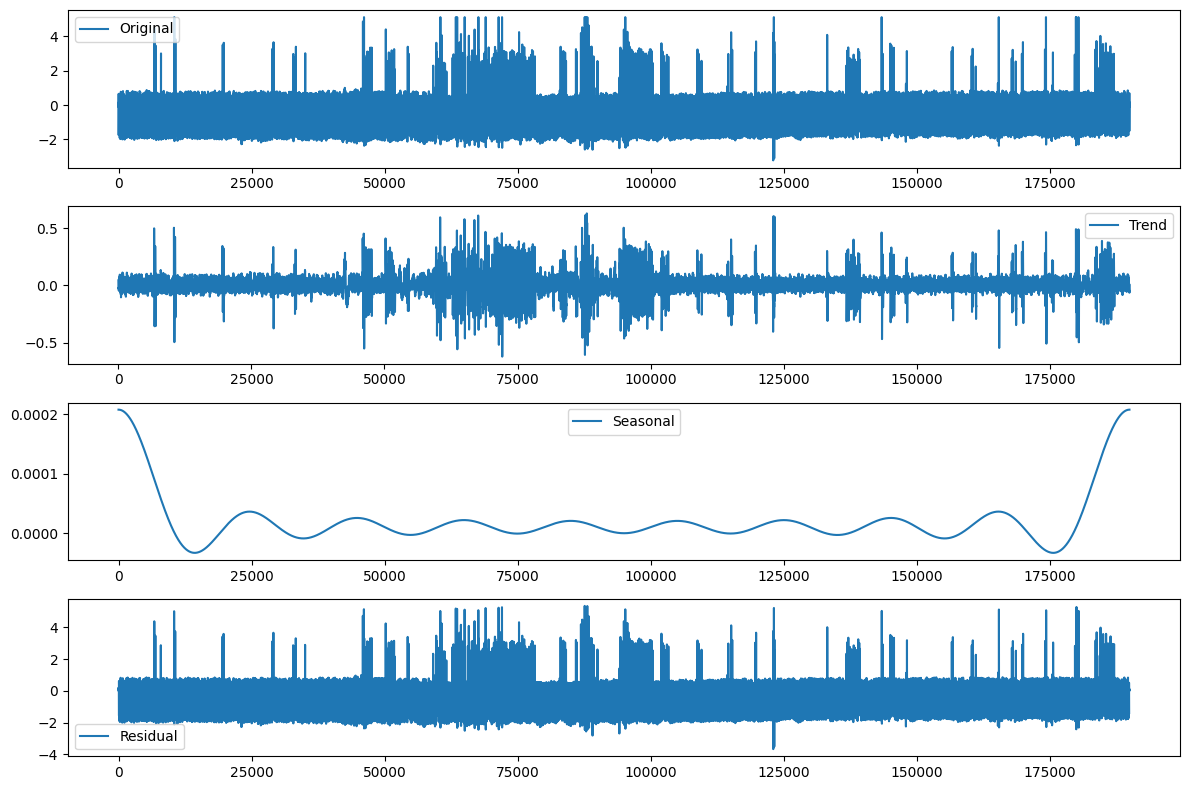

In [7]:
data_file = '/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/226_UCR_Anomaly_mit14046longtermecg_96123_123000_123300.txt'
data = np.loadtxt(data_file)
# detect_seasonality(data)
plot_decomposition(data_file)

使用的 window_size: 80


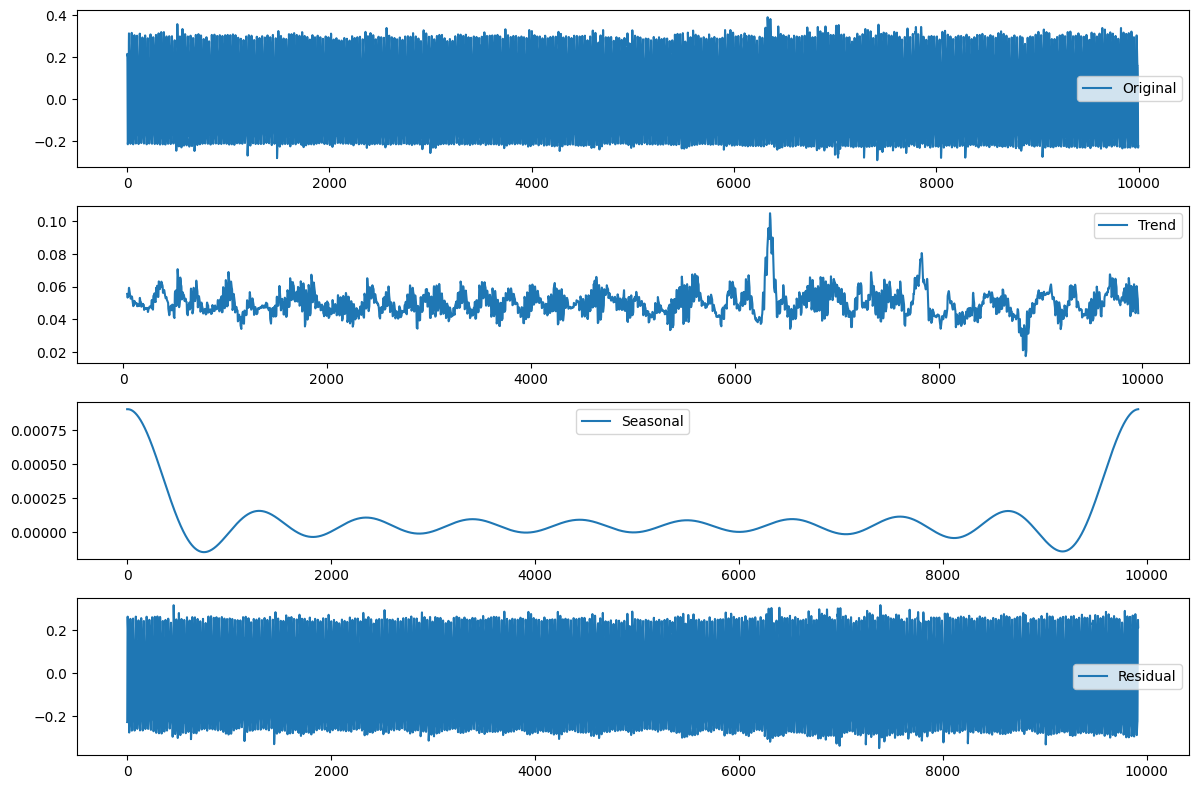

In [8]:
data_file = '/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/175_UCR_Anomaly_insectEPG3_5200_7000_7050.txt'
data = np.loadtxt(data_file)
# detect_seasonality(data)
plot_decomposition(data_file)

使用的 window_size: 80


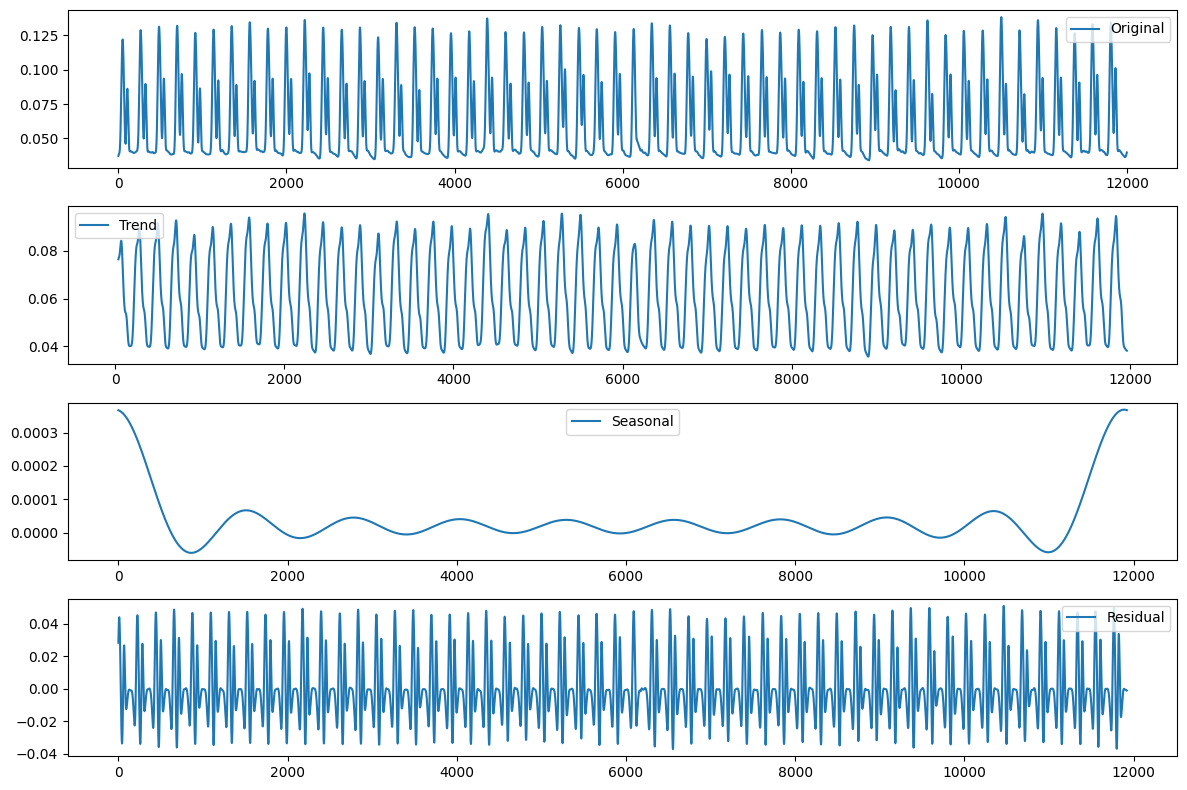

In [9]:
data_file = '/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/127_UCR_Anomaly_GP711MarkerLFM5z1_5000_6168_6212.txt'
data = np.loadtxt(data_file)
# detect_seasonality(data)
plot_decomposition(data_file)

使用的 window_size: 80


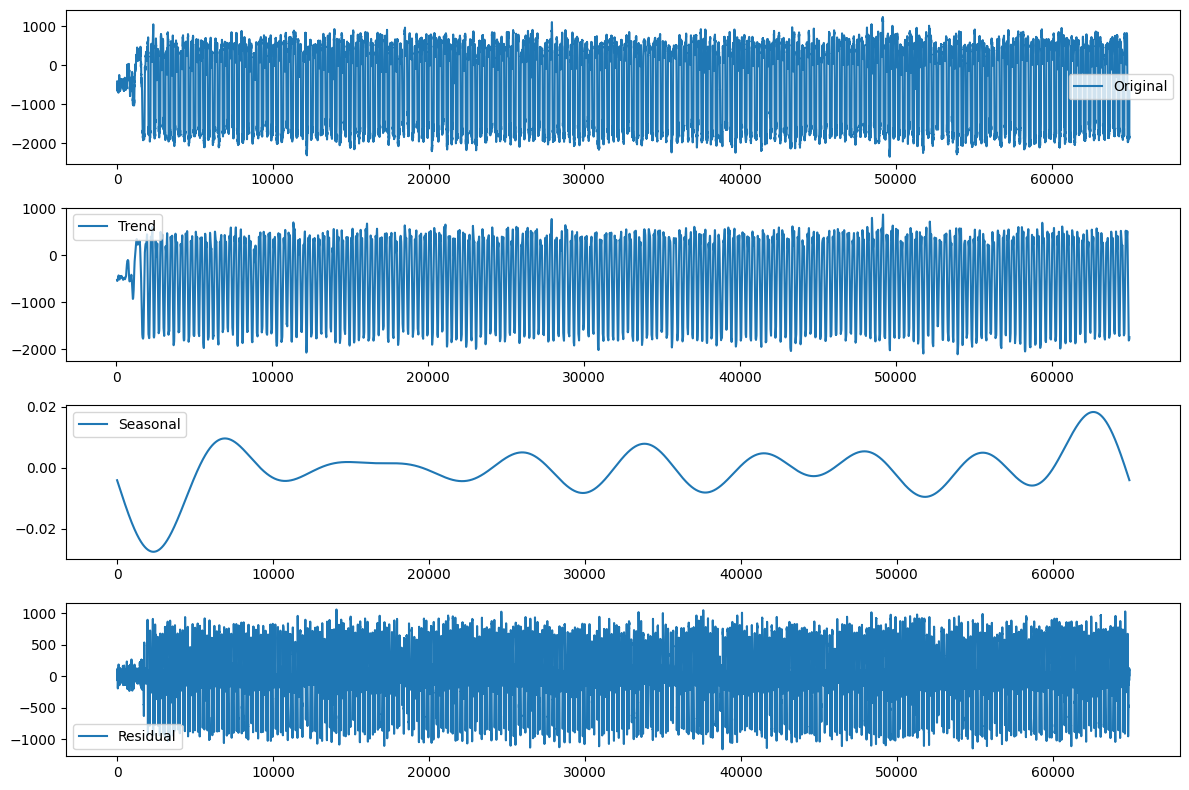

In [10]:
data_file = '/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/059_UCR_Anomaly_DISTORTEDgait1_20000_38500_38800.txt'
data = np.loadtxt(data_file)
# detect_seasonality(data)
plot_decomposition(data_file)

使用的 window_size: 80


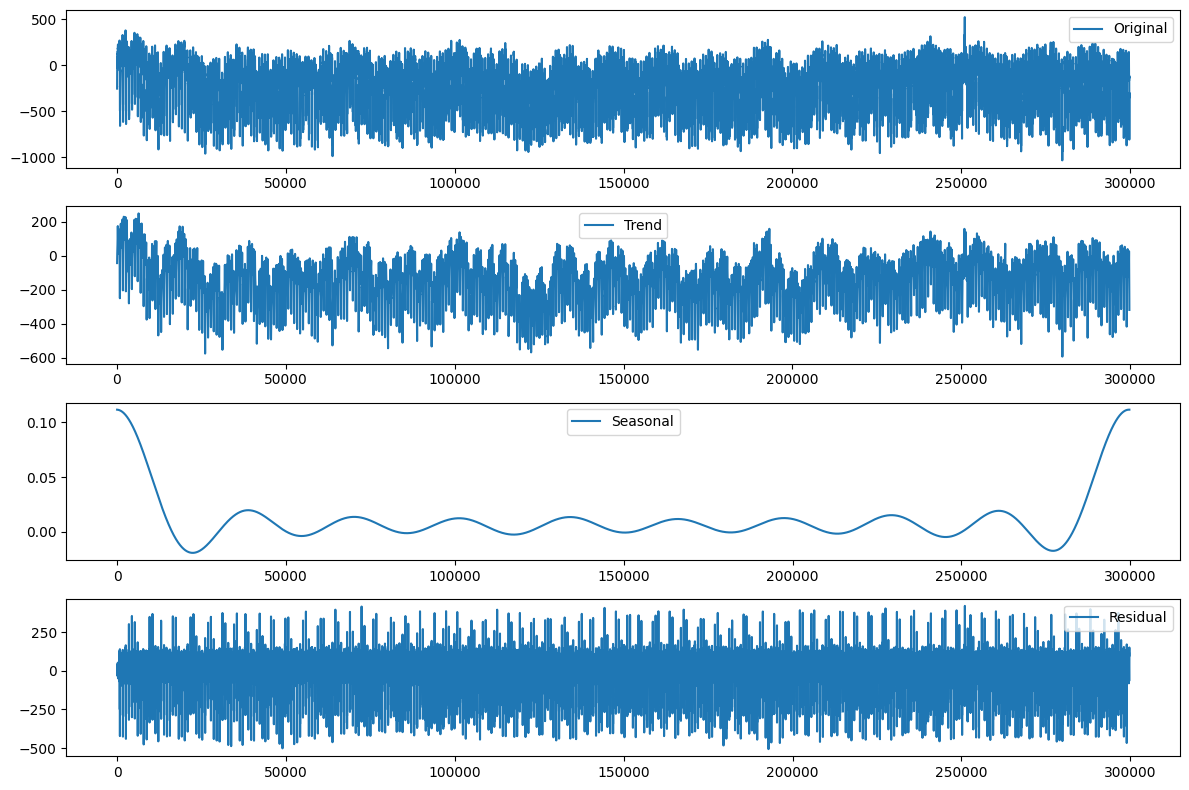

In [11]:
data_file = '/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/220_UCR_Anomaly_STAFFIIIDatabase_43217_250720_251370.txt'
data = np.loadtxt(data_file)
# detect_seasonality(data)|
plot_decomposition(data_file)

使用的 window_size: 80


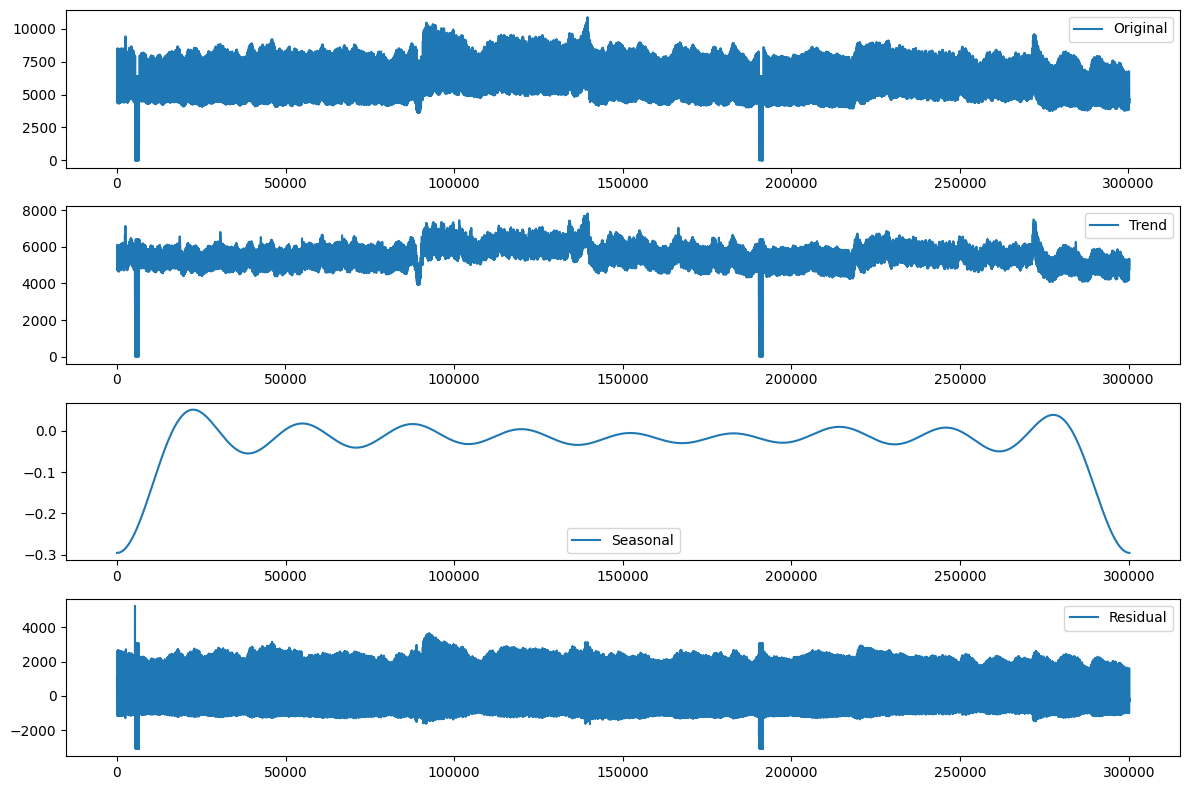

In [12]:
data_file = '/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/244_UCR_Anomaly_tilt12754table_100013_104630_104890.txt'
plot_decomposition(data_file)

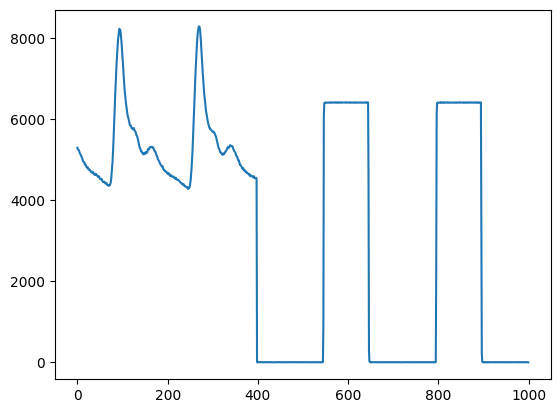

In [13]:
data = np.loadtxt(data_file)
plt.plot(data[190000:191000])

使用的 window_size: 80


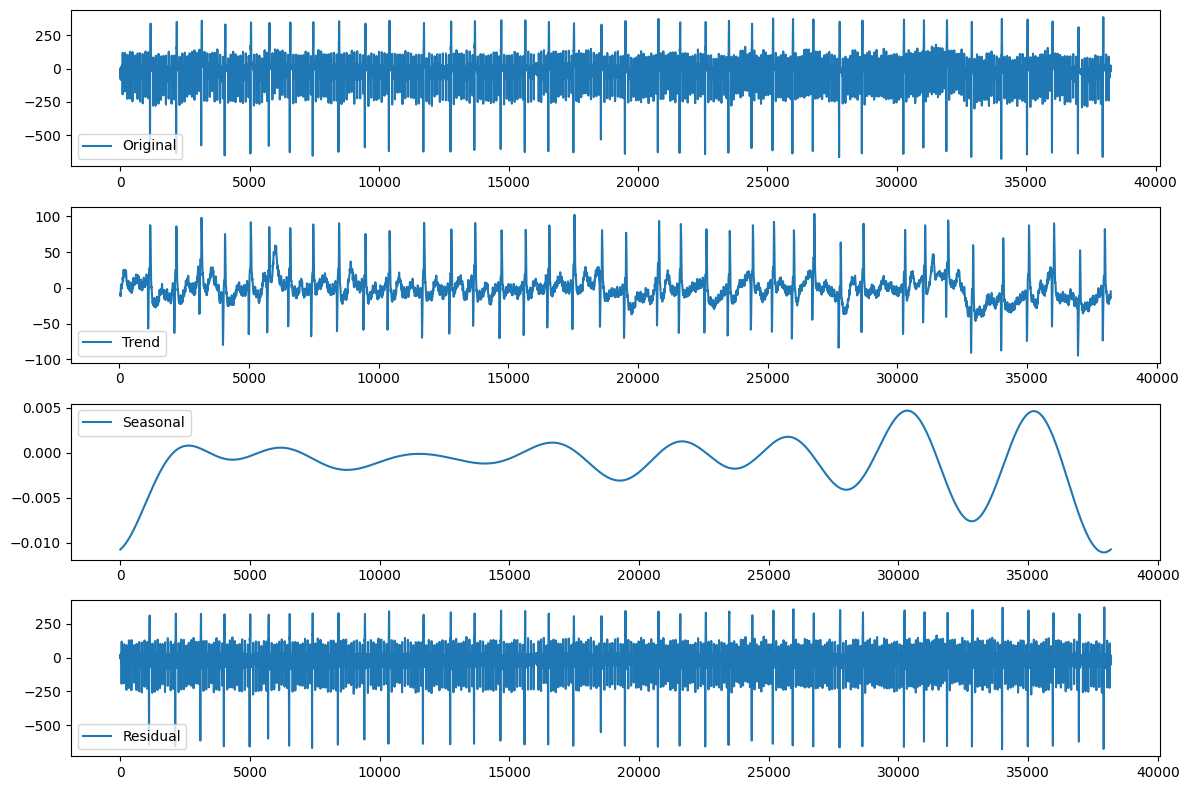

In [14]:
data_file = '/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/104_UCR_Anomaly_NOISEapneaecg4_6000_16000_16100.txt'
plot_decomposition(data_file)

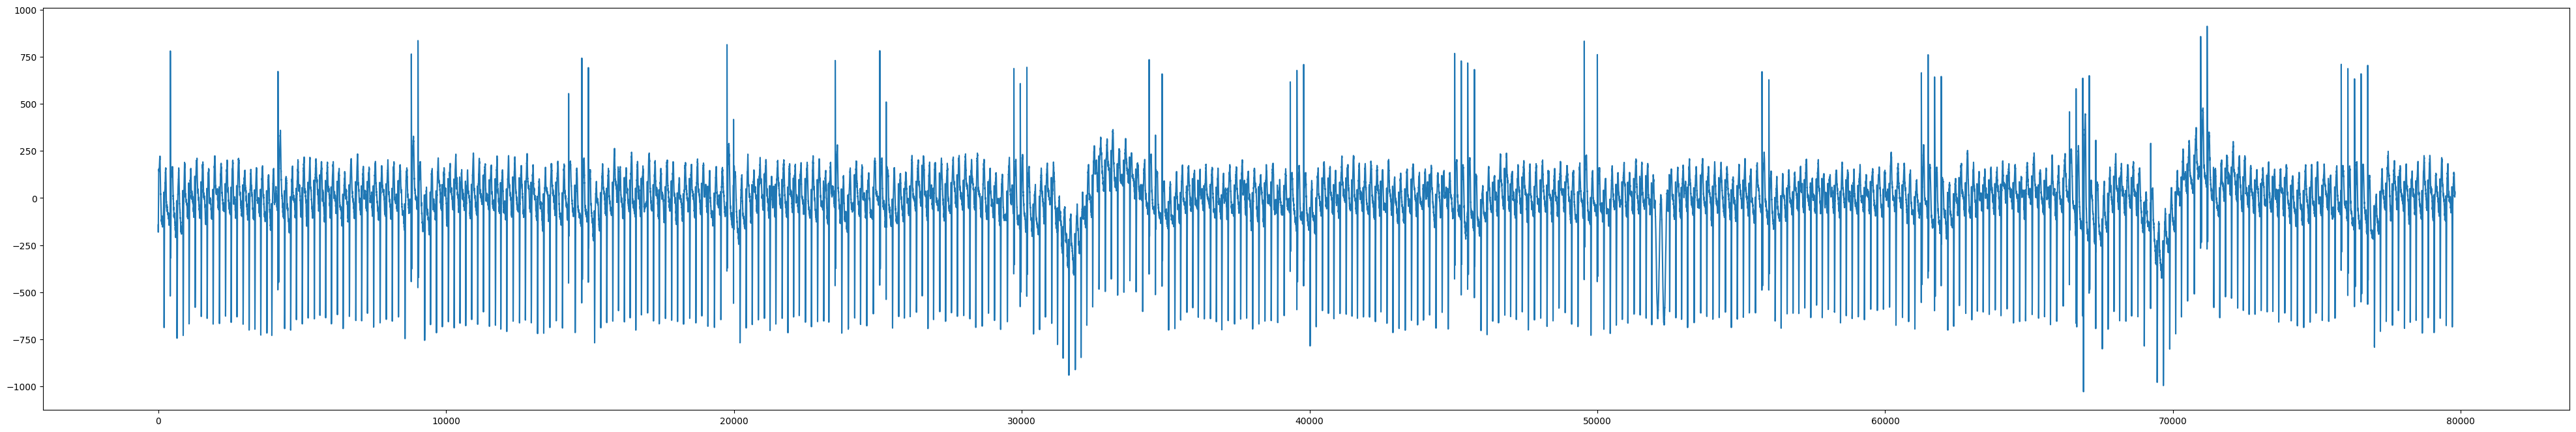

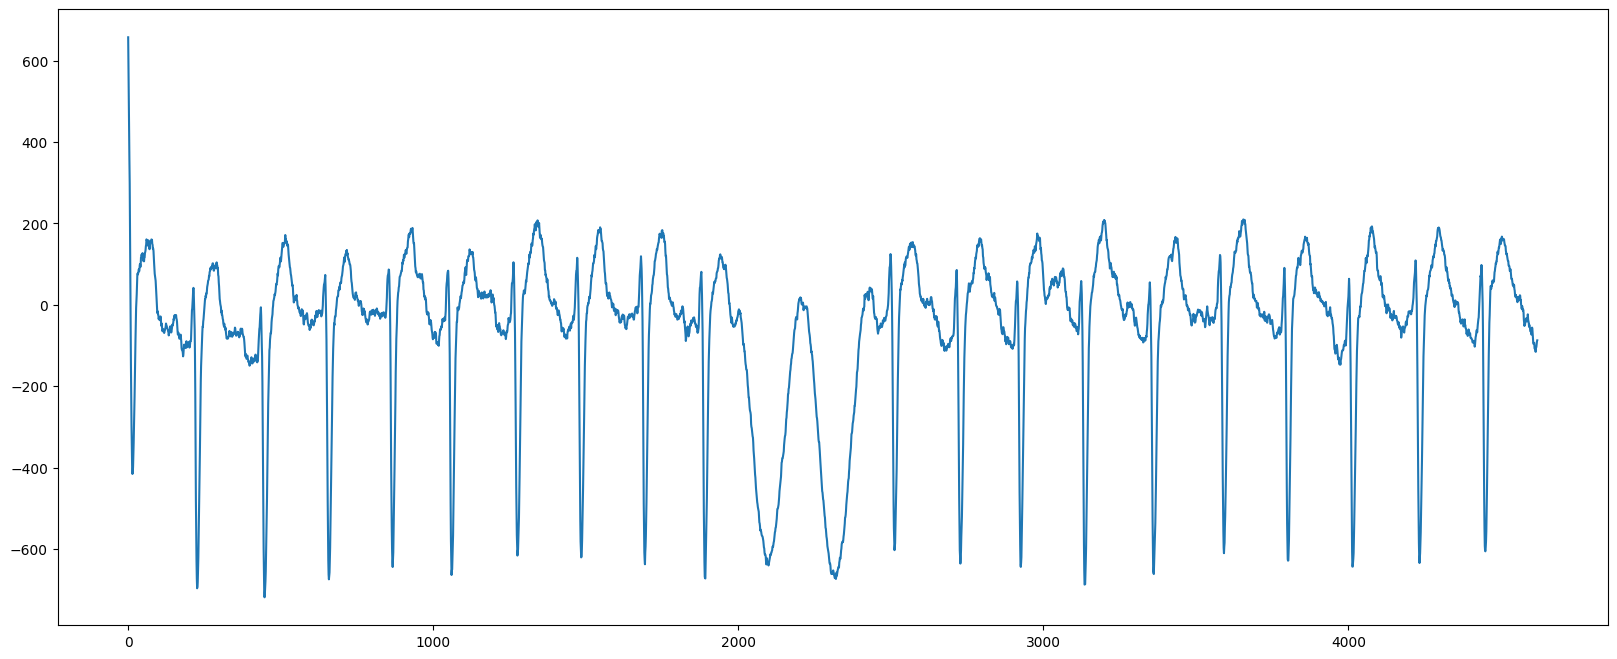

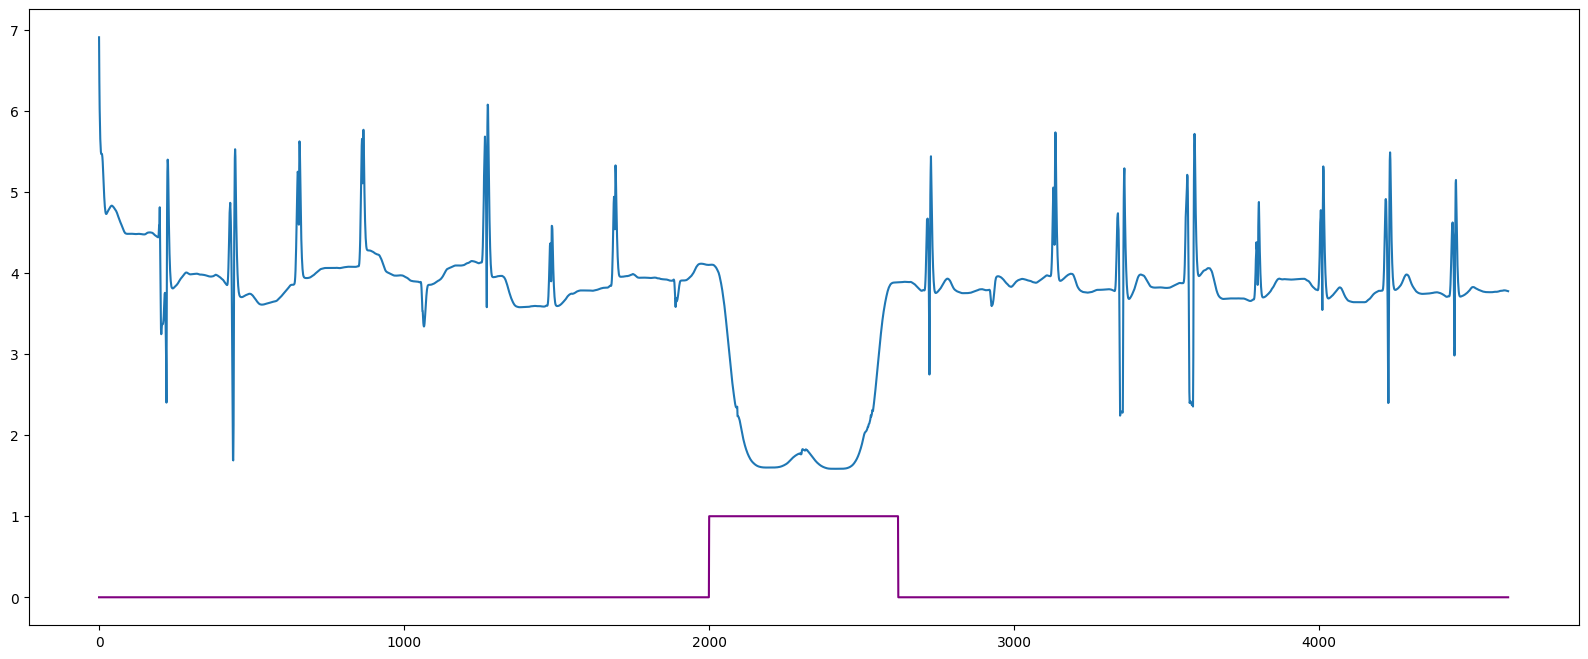

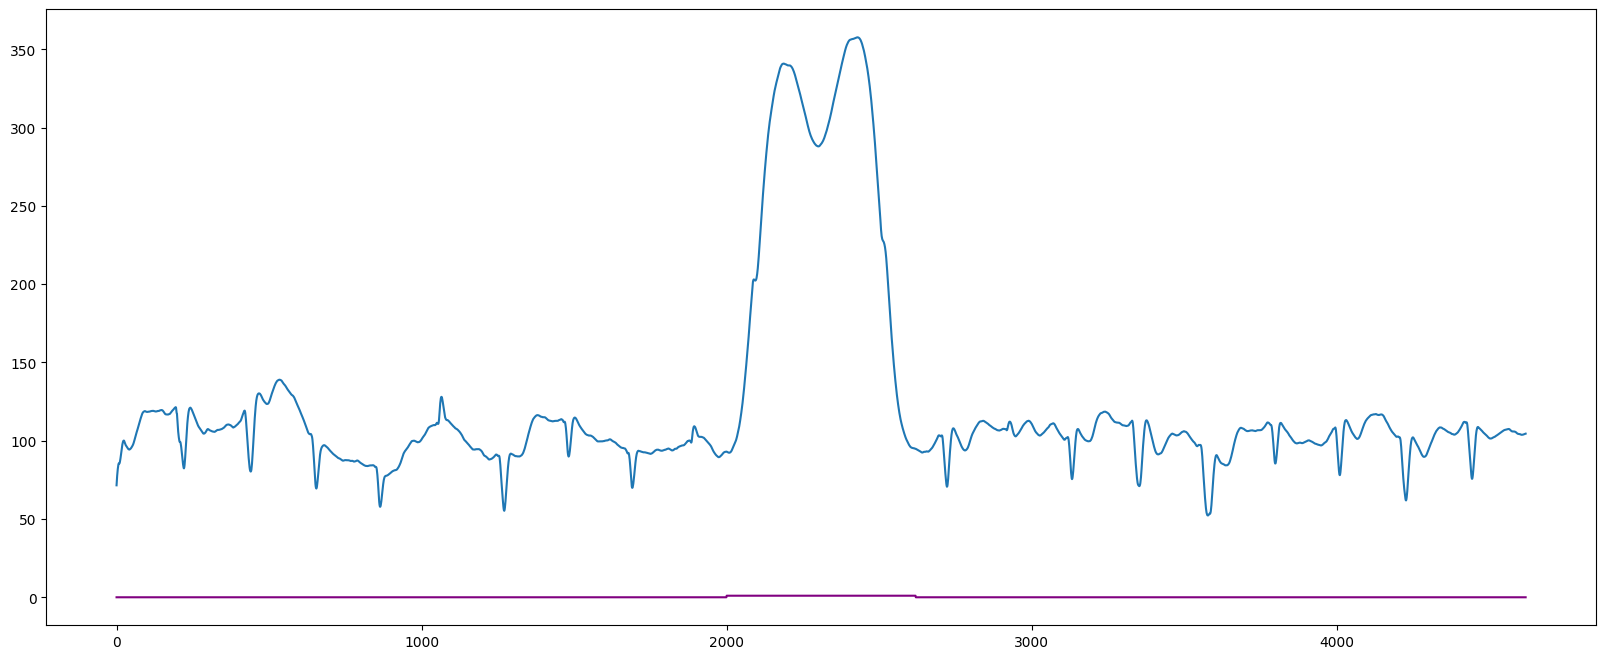

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据文件
data_file = '/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/001_UCR_Anomaly_DISTORTED1sddb40_35000_52000_52620.txt'
raw_data = np.loadtxt(data_file)
window=200
#异常区域
# 找到所有下划线的位置
underscore_indices = [i for i, char in enumerate(data_file) if char == '_']
# 找到最后一个点的位置
last_dot_index = data_file.rfind('.')
# 提取倒数第二个下划线后面的字符串
second_last_part = data_file[underscore_indices[-2] + 1:underscore_indices[-1]]
# 提取最后一个下划线之后的字符串
last_part = data_file[underscore_indices[-1] + 1:last_dot_index]
id=data_file[21:24]
a_start=int(second_last_part)
a_end=int(last_part)
plt.figure(figsize=(50,8))
plt.plot(raw_data)
plt.figure(figsize=(20,8))
plt.plot(raw_data[a_start-2000:a_end+2000])
# 定义计算裕度指标的函数
def cal_mos(data, window):
    mos_array = []
    for i in range(len(data) - window):
        segment = data[i:i + window]
        max_abs = np.max(np.abs(segment))
        mean_square = np.mean(np.square(segment))
        mos = max_abs / np.sqrt(mean_square)
        mos_array.append(mos)
    return mos_array

# 设置窗口大小
window = 200

# 计算裕度指标
mos_data = cal_mos(raw_data, window)

# 使用原始数据的前 window 个数据进行补充
initial_mos_data = cal_mos(np.concatenate([raw_data[:window]] * 2), window)
mos_data = initial_mos_data + mos_data


flag=np.zeros(len(mos_data))
flag[a_start:a_end]=1
#创建 x 数据
x = np.linspace(0, len(mos_data), len(mos_data))  # x 从 0 到 mos_data 的长度
# 平移 x 数据
x_shifted = x + window
plt.figure(figsize=(20,8))
plt.plot(mos_data[a_start-2000:a_end+2000],label='MOS')
plt.plot(flag[a_start-2000:a_end+2000], label='Flag', color='purple')

window = 200
#计算绝对平均值
def cal_mav(data, window):
    mav_array = []
    for i in range(len(data) - window):
        segment = data[i:i + window]
        mav = np.mean(np.abs(segment))
        mav_array.append(mav)
    return mav_array

mav_data = cal_mav(raw_data, window)
initial_mav_data = cal_mav(np.concatenate([raw_data[:window]] * 2), window)
mav_data = initial_mav_data + mav_data
plt.figure(figsize=(20,8))
plt.plot(mav_data[a_start-2000:a_end+2000],label='MAV')
plt.plot(flag[a_start-2000:a_end+2000], label='Flag', color='purple')
# 保存分解后的数据
base_filename = data_file.split('/')[-1].split('.')[0]
np.savetxt(f"/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/mav-{base_filename}.txt", mav_data)

In [16]:
# 保存分解后的数据
base_filename = data_file.split('/')[-1].split('.')[0]
np.savetxt(f"/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/mos-{base_filename}.txt", mos_data)


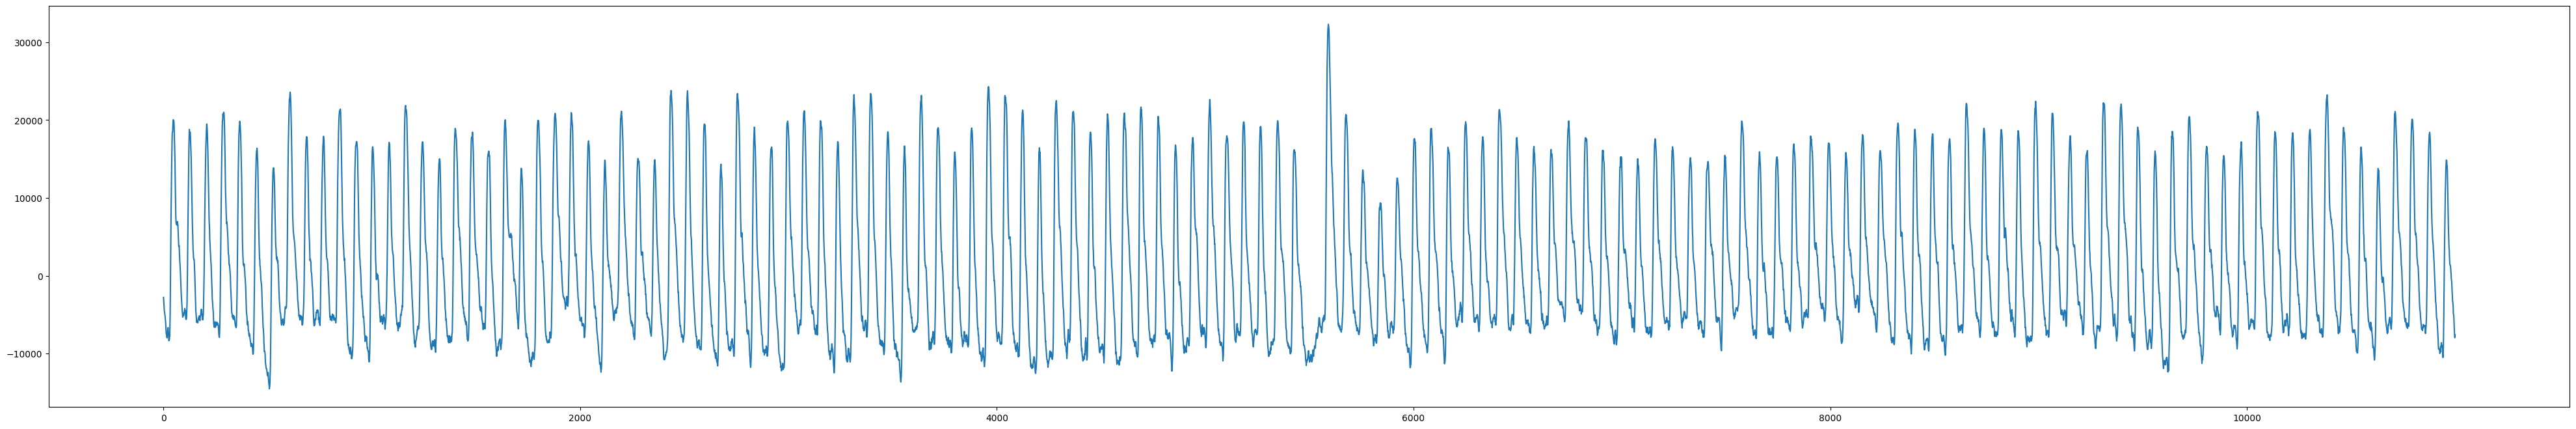

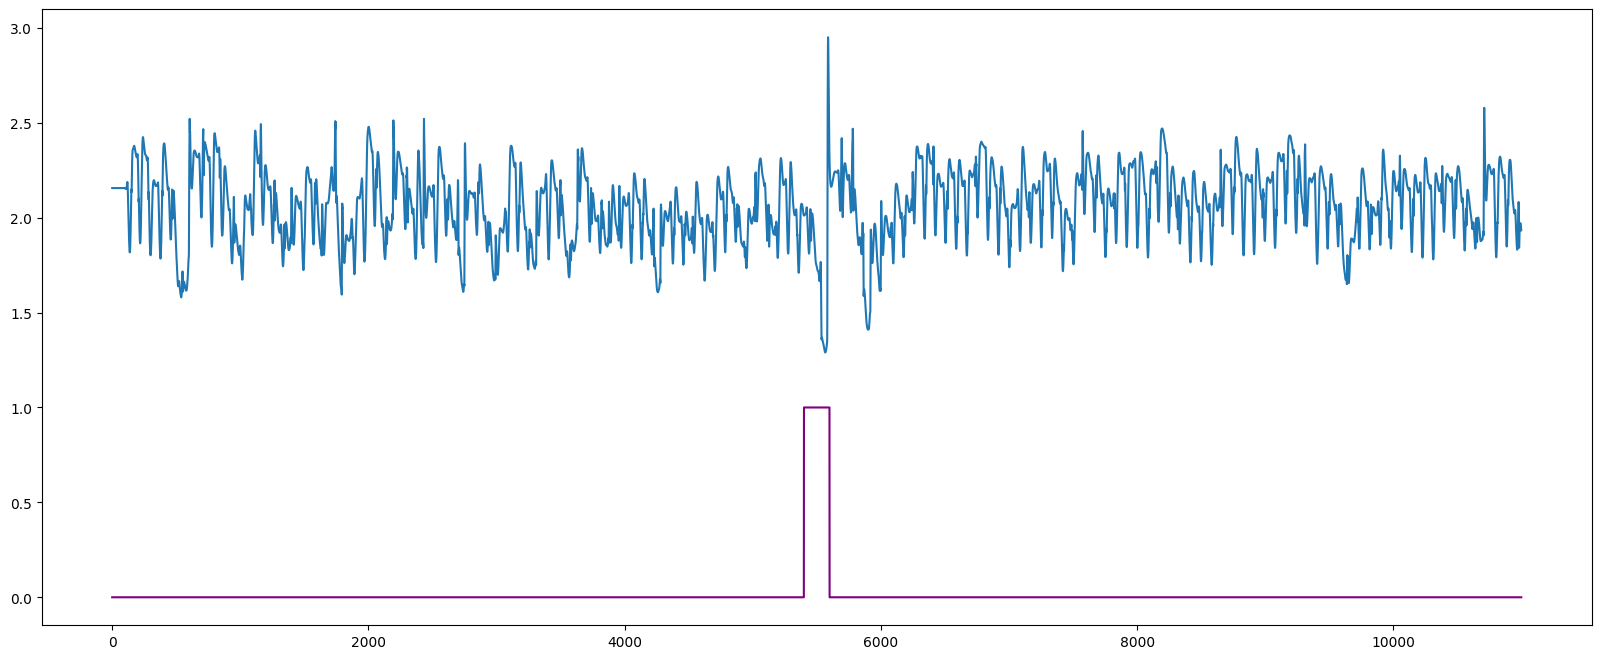

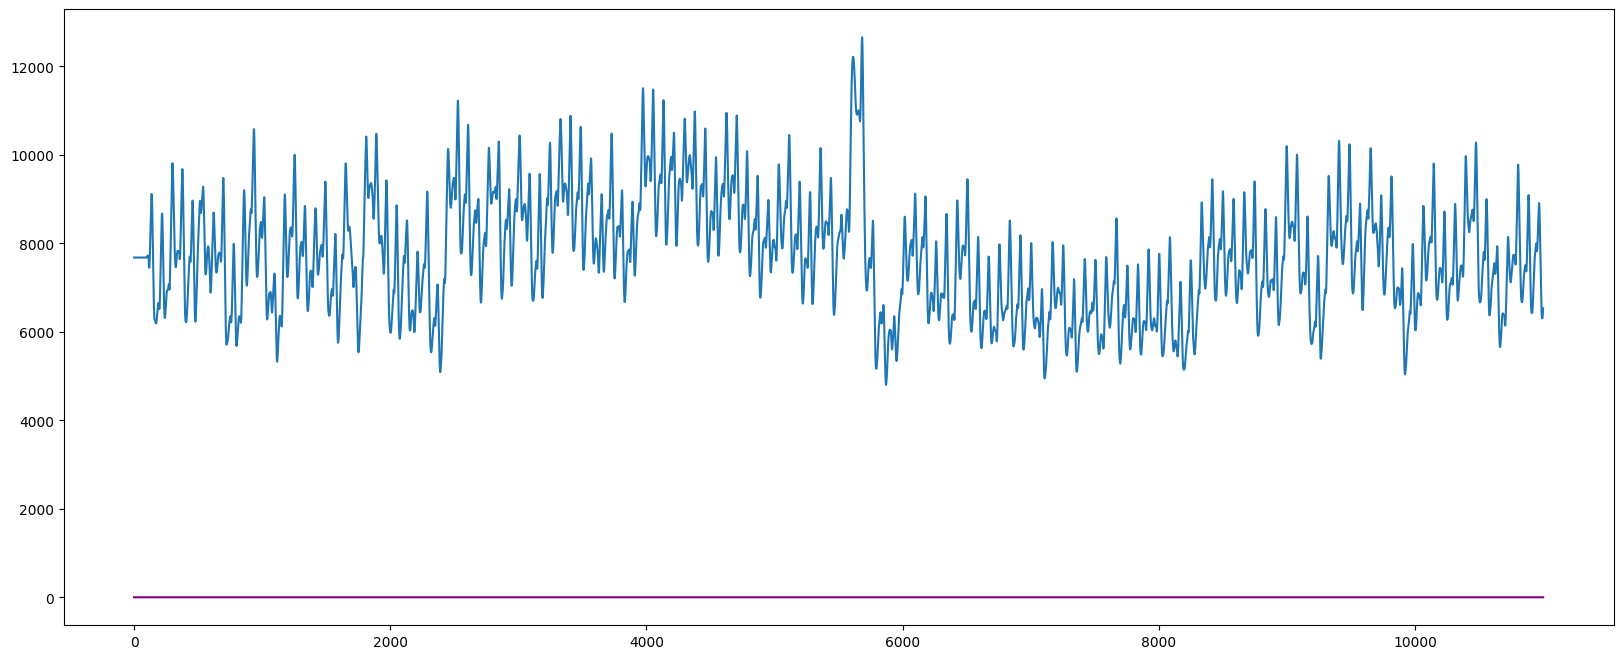

In [17]:
# 读取数据文件
data_file = '/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/004_UCR_Anomaly_DISTORTEDBIDMC1_2500_5400_5600.txt'
raw_data = np.loadtxt(data_file)
#异常区域
# 找到所有下划线的位置
underscore_indices = [i for i, char in enumerate(data_file) if char == '_']
# 找到最后一个点的位置
last_dot_index = data_file.rfind('.')
# 提取倒数第二个下划线后面的字符串
second_last_part = data_file[underscore_indices[-2] + 1:underscore_indices[-1]]
# 提取最后一个下划线之后的字符串
last_part = data_file[underscore_indices[-1] + 1:last_dot_index]
id=data_file[21:24]
a_start=int(second_last_part)
a_end=int(last_part)


plt.figure(figsize=(50,8))
plt.plot(raw_data)

# 设置窗口大小
window = 100

# 计算裕度指标
mos_data = cal_mos(raw_data, window)

# 使用原始数据的前 window 个数据进行补充
initial_mos_data = cal_mos(np.concatenate([raw_data[:window]] * 2), window)
mos_data = initial_mos_data + mos_data


flag=np.zeros(len(mos_data))
flag[a_start:a_end]=1
#创建 x 数据
x = np.linspace(0, len(mos_data), len(mos_data))  # x 从 0 到 mos_data 的长度
# 平移 x 数据
x_shifted = x + window
plt.figure(figsize=(20,8))
plt.plot(mos_data,label='MOS')
plt.plot(flag, label='Flag', color='purple')



mav_data = cal_mav(raw_data, window)
initial_mav_data = cal_mav(np.concatenate([raw_data[:window]] * 2), window)
mav_data = initial_mav_data + mav_data

plt.figure(figsize=(20,8))
plt.plot(mav_data,label='MAV')
plt.plot(flag, label='Flag', color='purple')


# 保存分解后的数据
base_filename = data_file.split('/')[-1].split('.')[0]
np.savetxt(f"/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/mos-{base_filename}.txt", mos_data)

np.savetxt(f"/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/mav-{base_filename}.txt",mav_data)

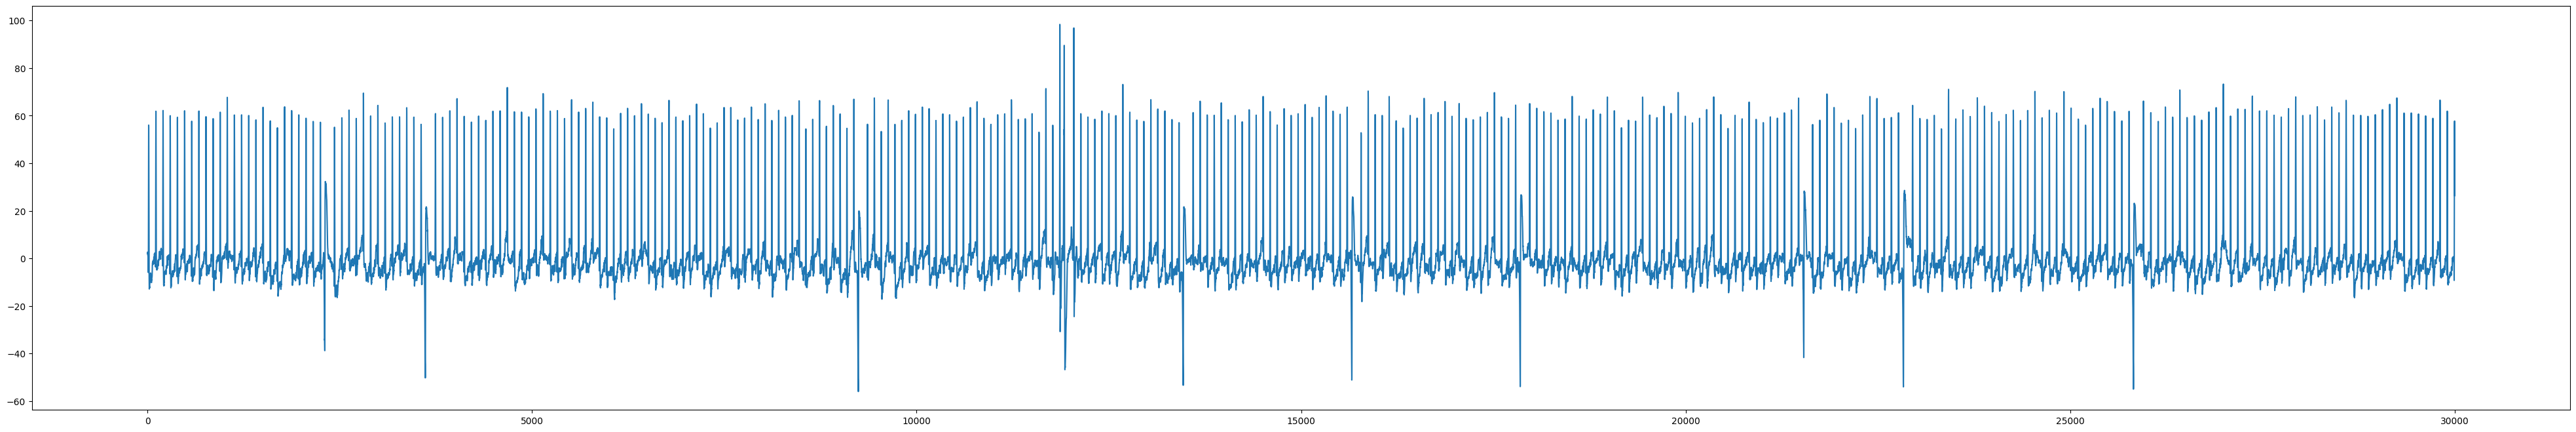

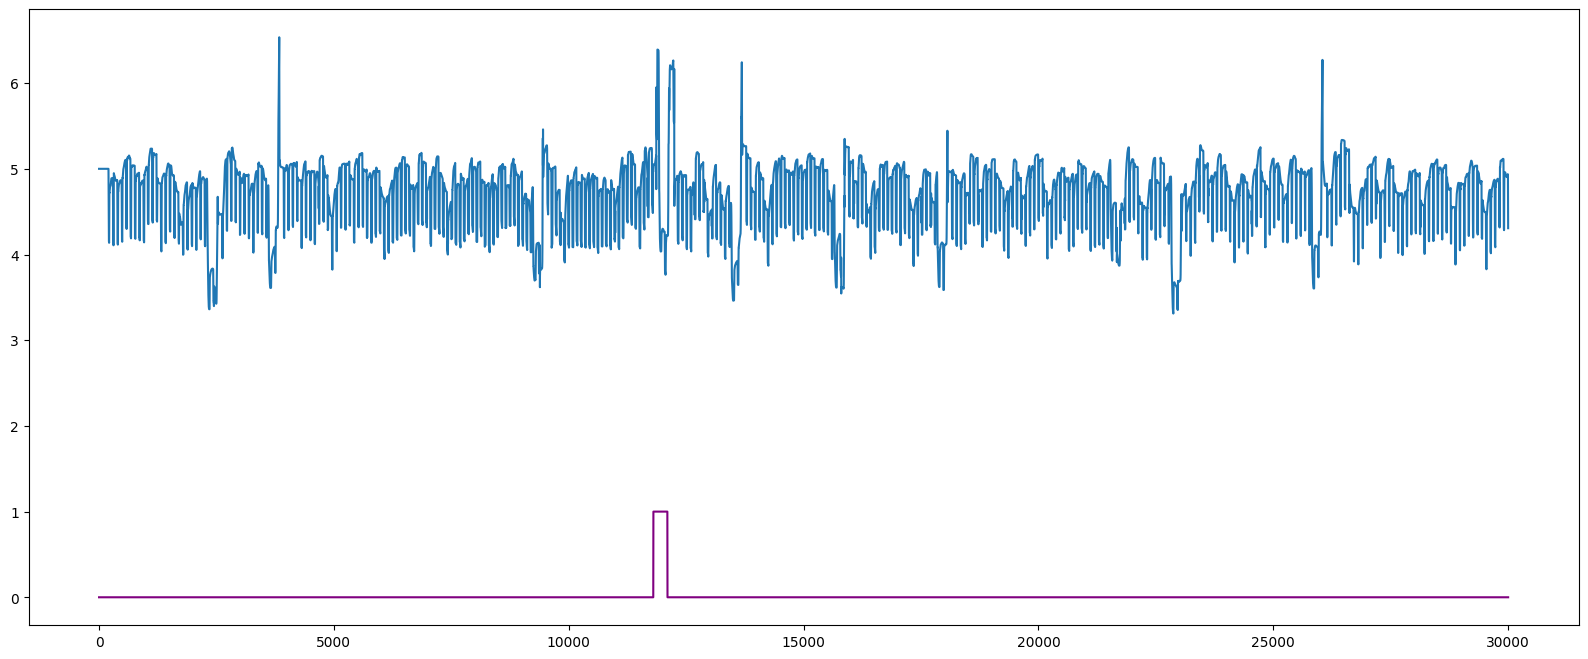

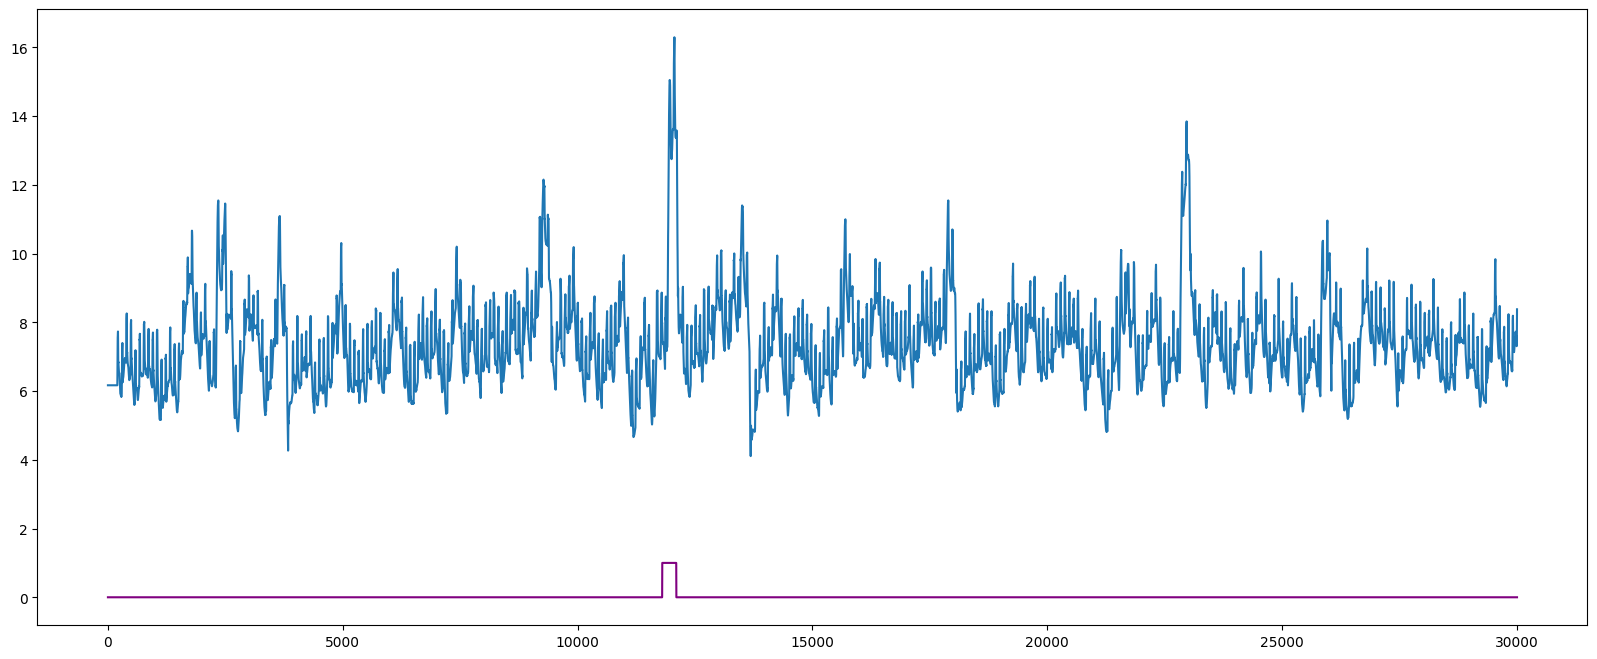

In [24]:
# 读取数据文件
data_file = '/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/011_UCR_Anomaly_DISTORTEDECG1_10000_11800_12100.txt'
raw_data = np.loadtxt(data_file)
#异常区域
# 找到所有下划线的位置
underscore_indices = [i for i, char in enumerate(data_file) if char == '_']
# 找到最后一个点的位置
last_dot_index = data_file.rfind('.')
# 提取倒数第二个下划线后面的字符串
second_last_part = data_file[underscore_indices[-2] + 1:underscore_indices[-1]]
# 提取最后一个下划线之后的字符串
last_part = data_file[underscore_indices[-1] + 1:last_dot_index]
id=data_file[21:24]
a_start=int(second_last_part)
a_end=int(last_part)


plt.figure(figsize=(50,8))
plt.plot(raw_data)


# 设置窗口大小
window = 200

# 计算裕度指标
mos_data = cal_mos(raw_data, window)

# 使用原始数据的前 window 个数据进行补充
initial_mos_data = cal_mos(np.concatenate([raw_data[:window]] * 2), window)
mos_data = initial_mos_data + mos_data


flag=np.zeros(len(mos_data))
flag[a_start:a_end]=1
#创建 x 数据
x = np.linspace(0, len(mos_data), len(mos_data))  # x 从 0 到 mos_data 的长度
# 平移 x 数据
x_shifted = x + window
plt.figure(figsize=(20,8))
plt.plot(mos_data,label='MOS')
plt.plot(flag, label='Flag', color='purple')



mav_data = cal_mav(raw_data, window)
initial_mav_data = cal_mav(np.concatenate([raw_data[:window]] * 2), window)
mav_data = initial_mav_data + mav_data

plt.figure(figsize=(20,8))
plt.plot(mav_data,label='MAV')
plt.plot(flag, label='Flag', color='purple')




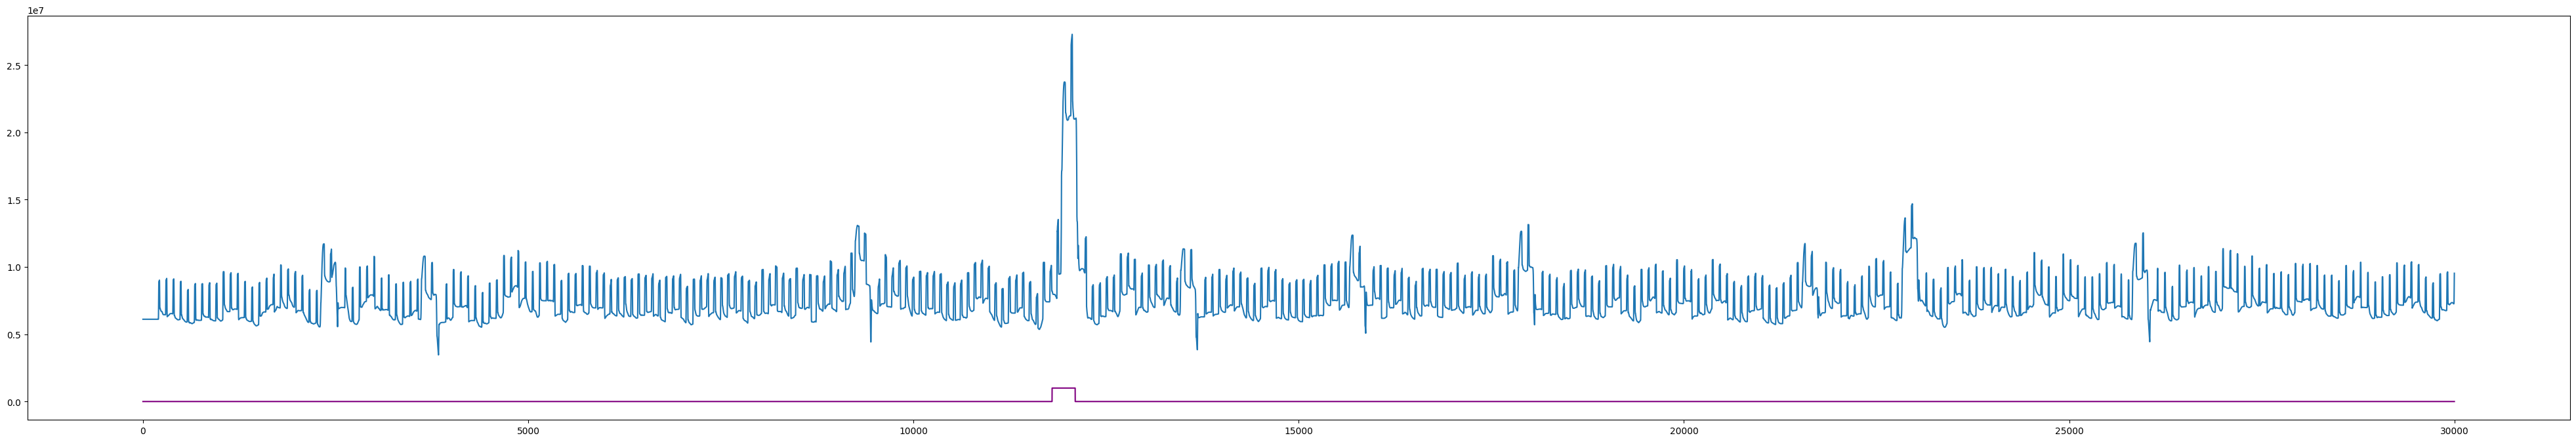

In [28]:

# 设置窗口大小
window = 200

# 频域总能量
def cal_fte(data, window):
    fte_array = []
    for i in range(len(data) - window):
        segment = data[i:i + window]
        fte = np.sum(np.square(np.abs(np.fft.fft(segment))))
        fte_array.append(fte)
    return fte_array

fte_data = cal_fte(raw_data, window)
initial_fte_data = cal_fte(np.concatenate([raw_data[:window]] * 2), window)
fte_data = initial_fte_data + fte_data

flag=np.zeros(len(fte_data))
flag[a_start:a_end]=1
#创建 x 数据
x = np.linspace(0, len(fte_data), len(fte_data))  # x 从 0 到 mos_data 的长度
# 平移 x 数据
x_shifted = x + window
plt.figure(figsize=(50,8))
plt.plot(fte_data,label='FTE')
plt.plot(flag*1000000, label='Flag', color='purple')

# 保存分解后的数据
base_filename = data_file.split('/')[-1].split('.')[0]
np.savetxt(f"/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/fte-{base_filename}.txt",fte_data)



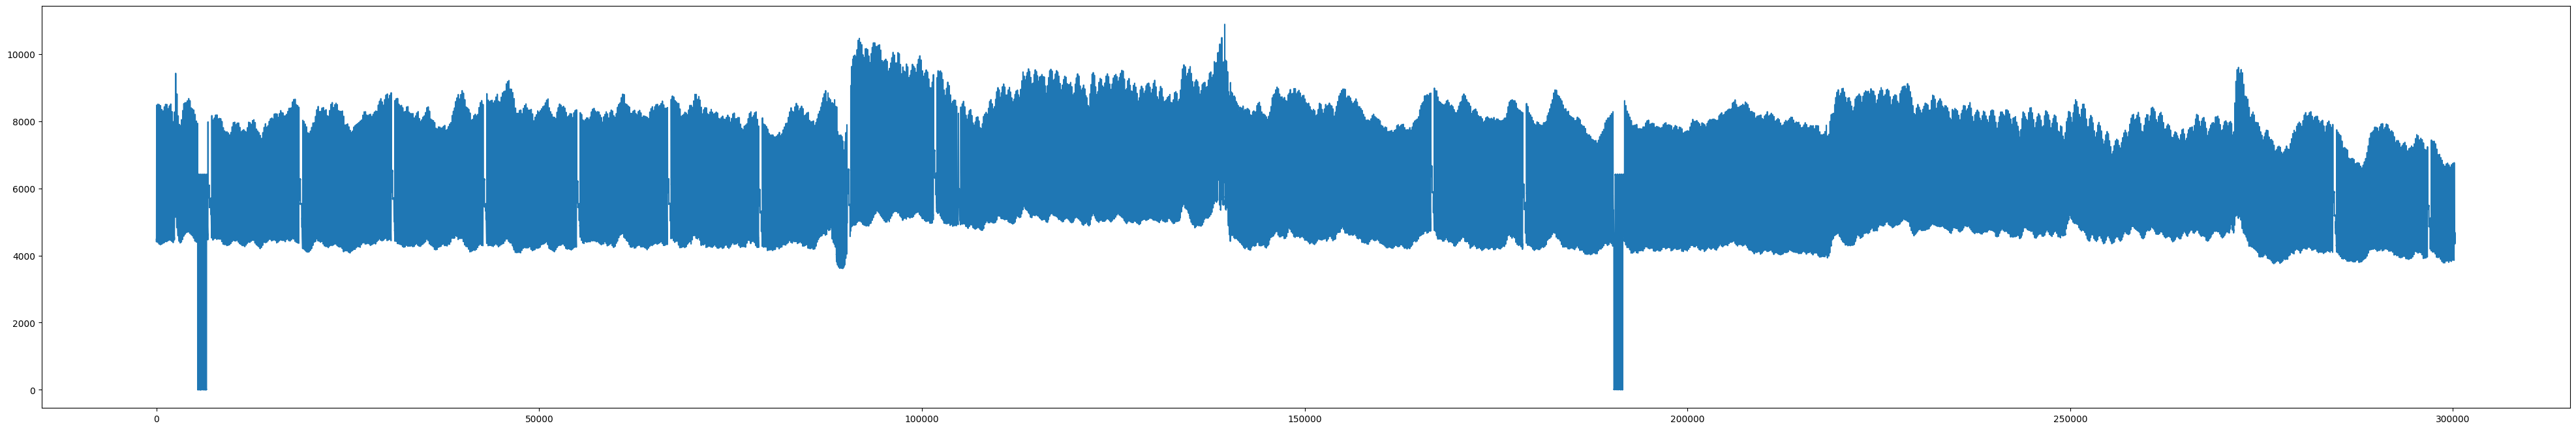

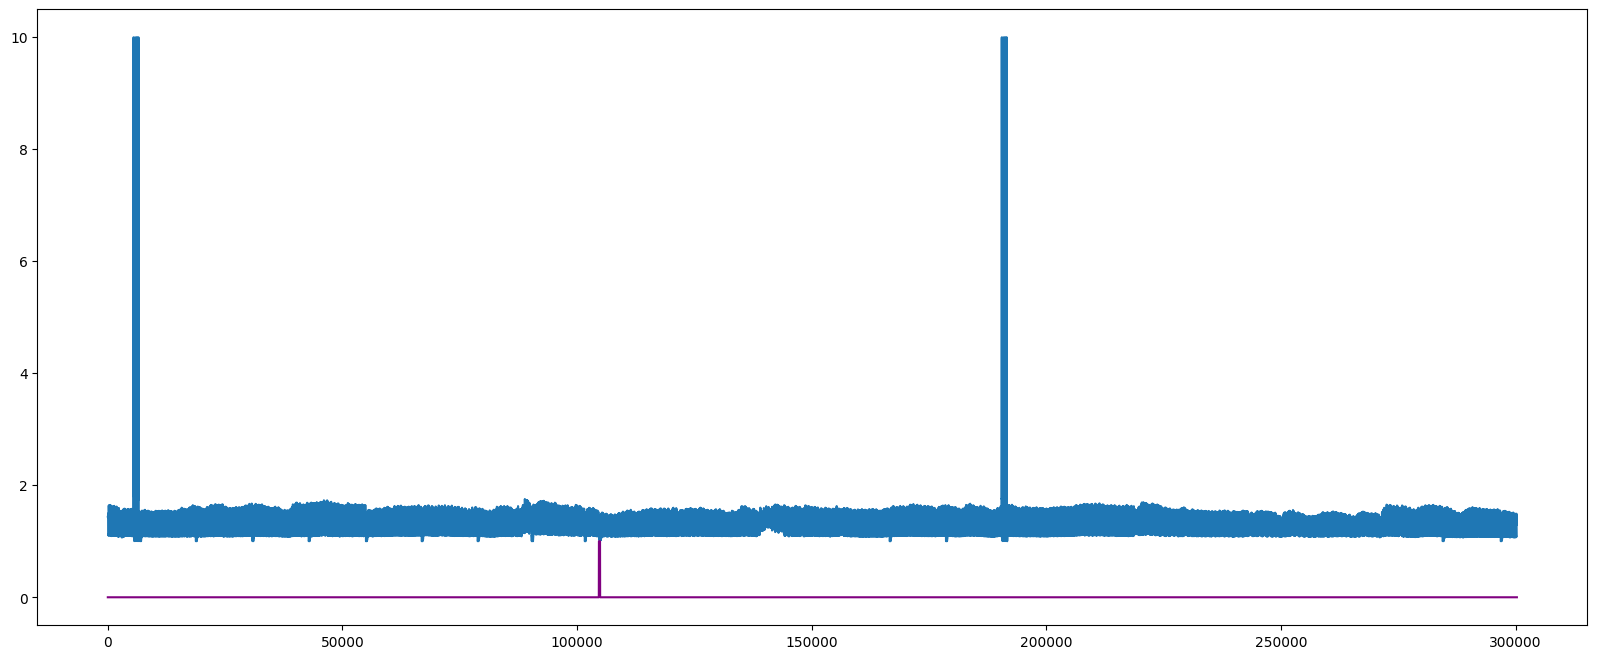

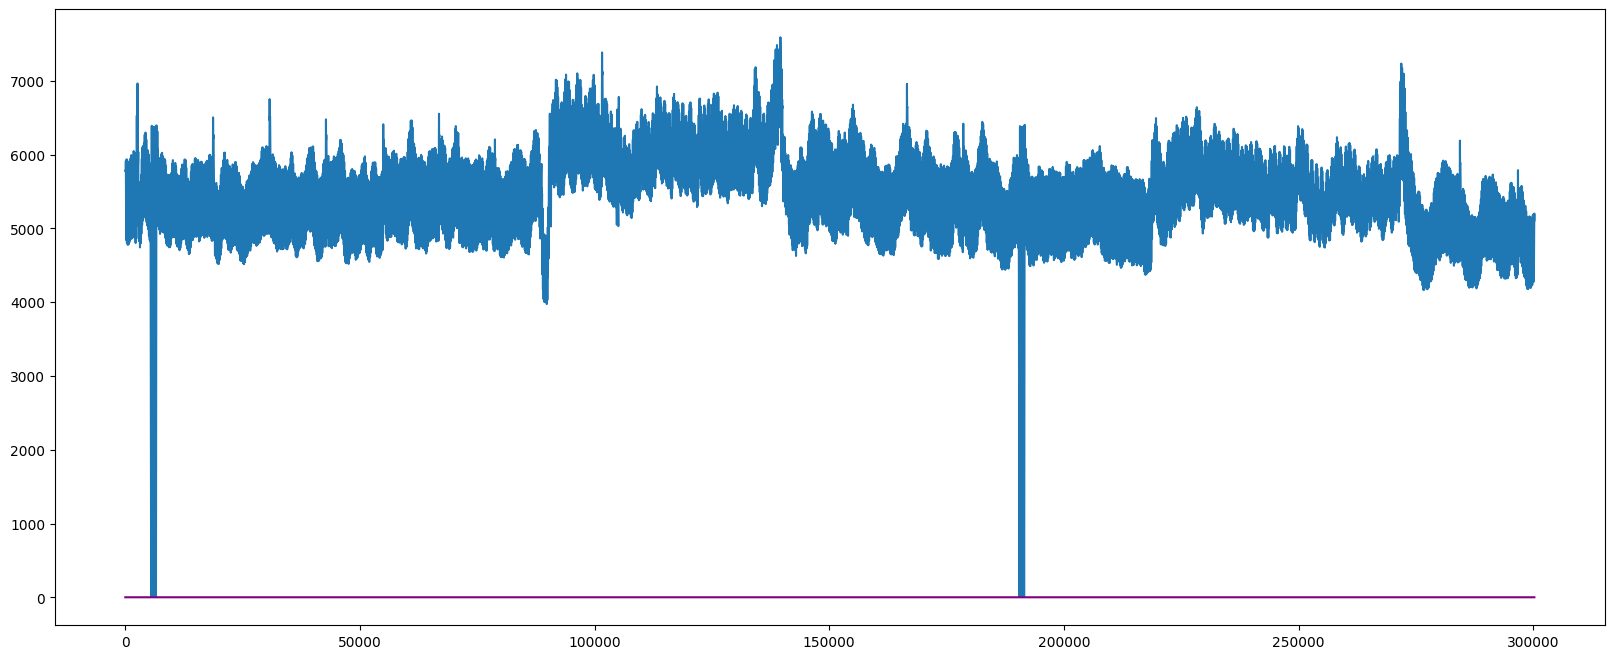

In [31]:
# 读取数据文件
data_file = '/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/244_UCR_Anomaly_tilt12754table_100013_104630_104890.txt'
raw_data = np.loadtxt(data_file)
#异常区域
# 找到所有下划线的位置
underscore_indices = [i for i, char in enumerate(data_file) if char == '_']
# 找到最后一个点的位置
last_dot_index = data_file.rfind('.')
# 提取倒数第二个下划线后面的字符串
second_last_part = data_file[underscore_indices[-2] + 1:underscore_indices[-1]]
# 提取最后一个下划线之后的字符串
last_part = data_file[underscore_indices[-1] + 1:last_dot_index]
id=data_file[21:24]
a_start=int(second_last_part)
a_end=int(last_part)


plt.figure(figsize=(50,8))
plt.plot(raw_data)

# 设置窗口大小
window = 100

# 计算裕度指标
mos_data = cal_mos(raw_data, window)

# 使用原始数据的前 window 个数据进行补充
initial_mos_data = cal_mos(np.concatenate([raw_data[:window]] * 2), window)
mos_data = initial_mos_data + mos_data


flag=np.zeros(len(mos_data))
flag[a_start:a_end]=1
#创建 x 数据
x = np.linspace(0, len(mos_data), len(mos_data))  # x 从 0 到 mos_data 的长度
# 平移 x 数据
x_shifted = x + window
plt.figure(figsize=(20,8))
plt.plot(mos_data,label='MOS')
plt.plot(flag, label='Flag', color='purple')



mav_data = cal_mav(raw_data, window)
initial_mav_data = cal_mav(np.concatenate([raw_data[:window]] * 2), window)
mav_data = initial_mav_data + mav_data

plt.figure(figsize=(20,8))
plt.plot(mav_data,label='MAV')
plt.plot(flag, label='Flag', color='purple')


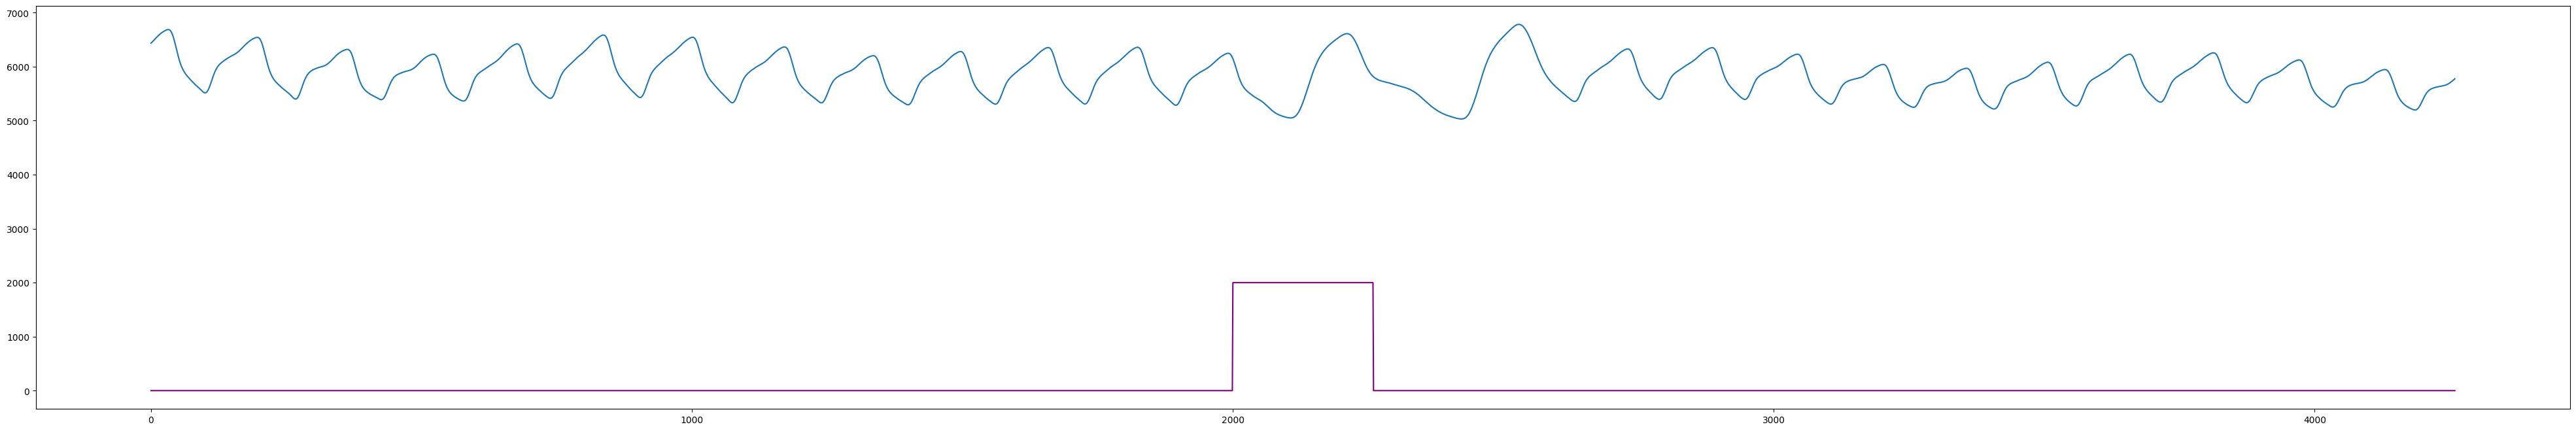

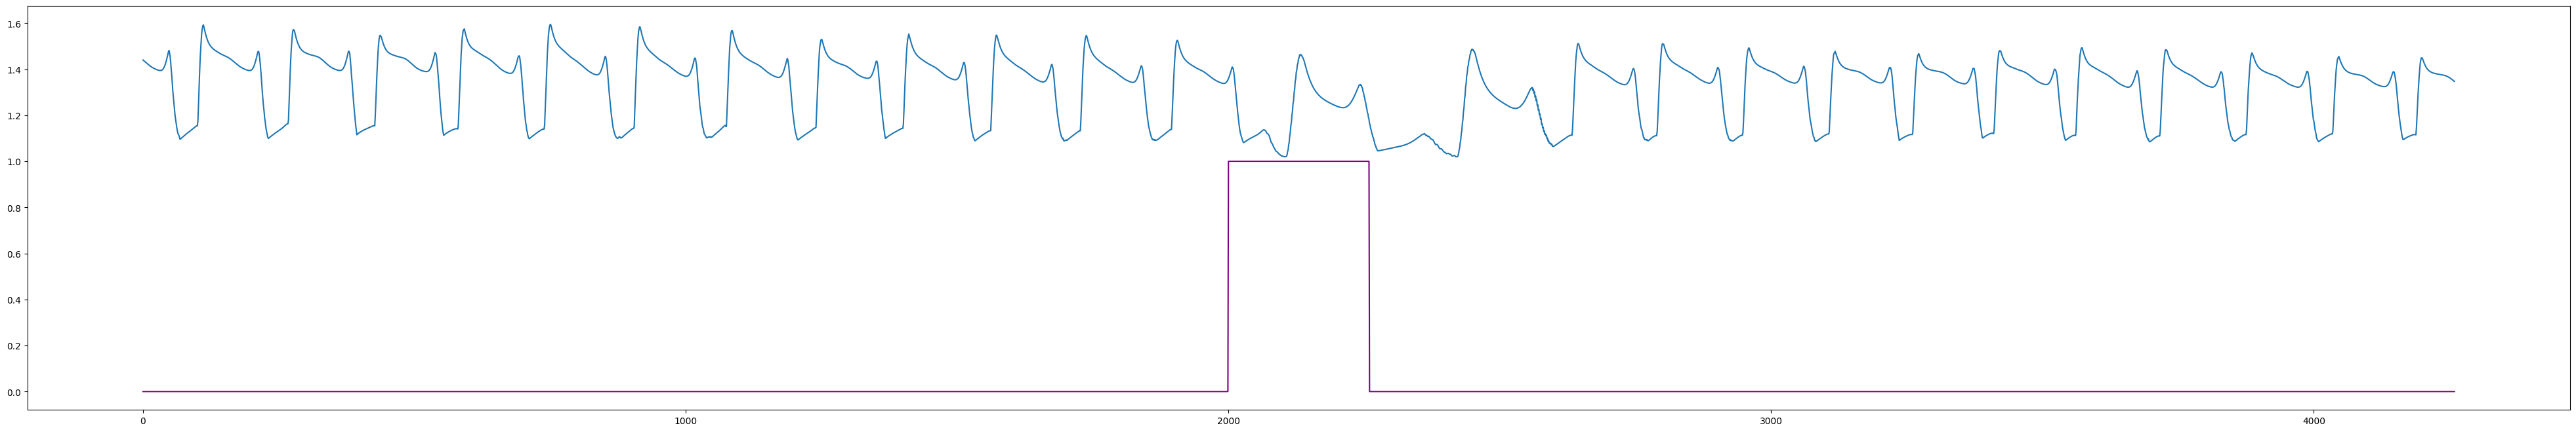

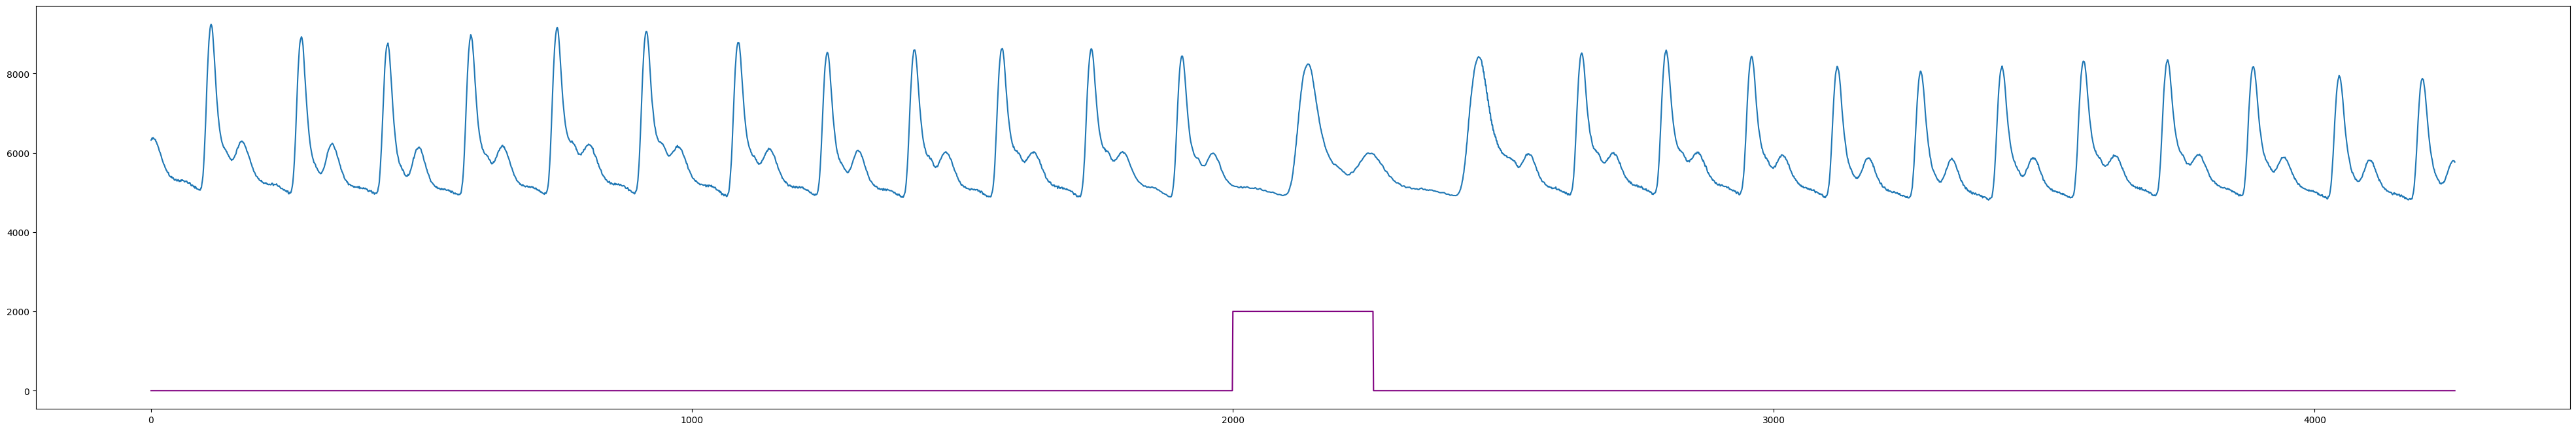

In [38]:
plt.figure(figsize=(50,8))
plt.plot(mav_data[104630-2000:104890+2000])
plt.plot(flag[104630-2000:104890+2000]*2000, label='Flag', color='purple')

plt.figure(figsize=(50,8))
plt.plot(mos_data[104630-2000:104890+2000])
plt.plot(flag[104630-2000:104890+2000], label='Flag', color='purple')

plt.figure(figsize=(50,8))
plt.plot(raw_data[104630-2000:104890+2000])
plt.plot(flag[104630-2000:104890+2000]*2000, label='Flag', color='purple')

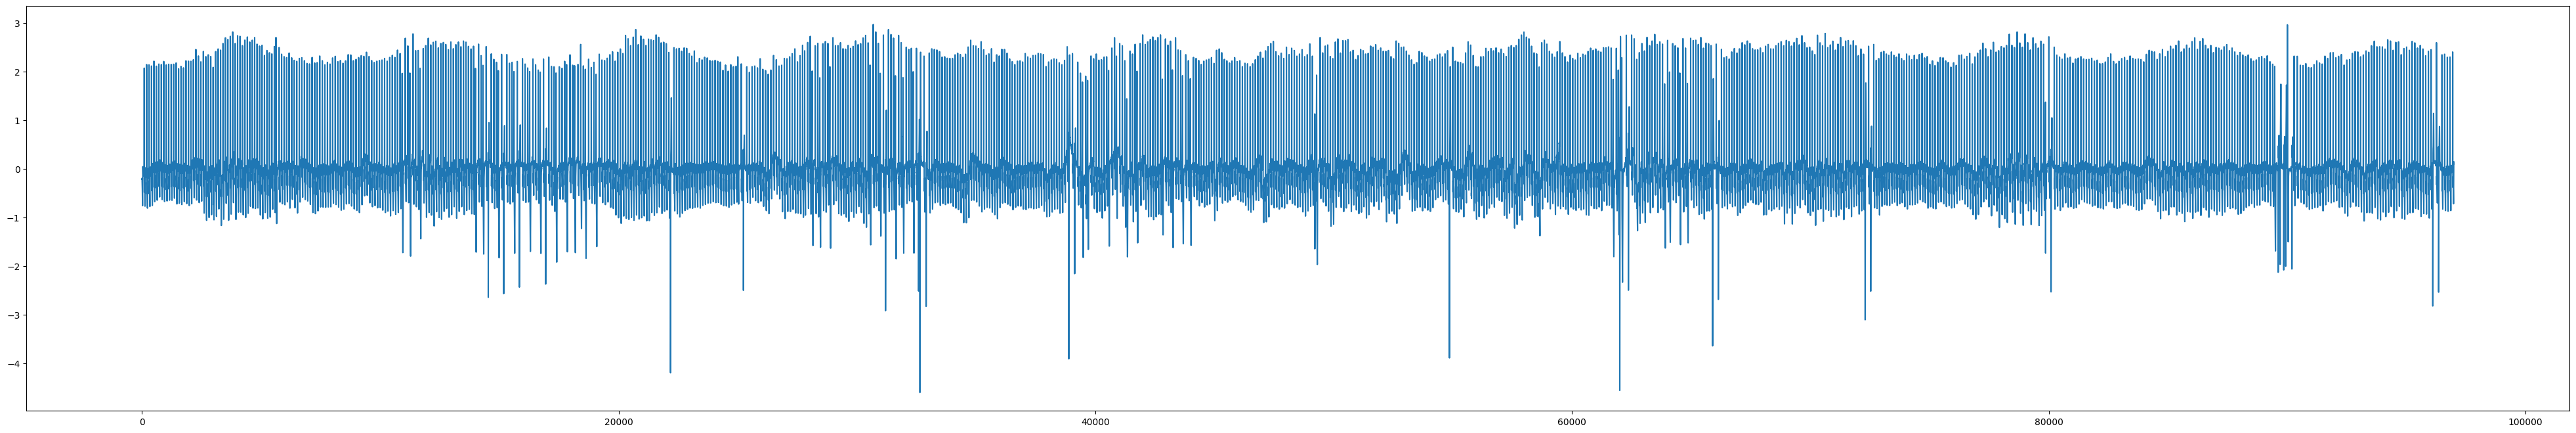

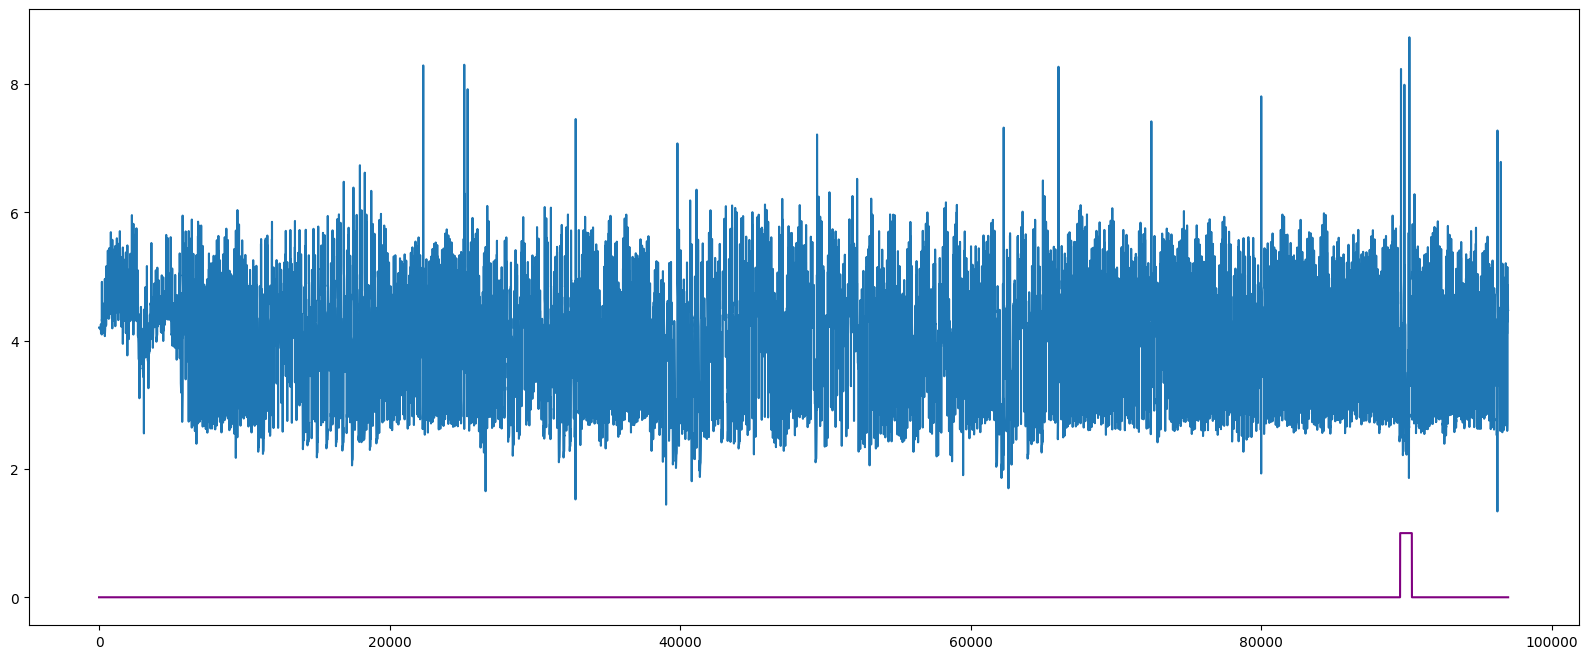

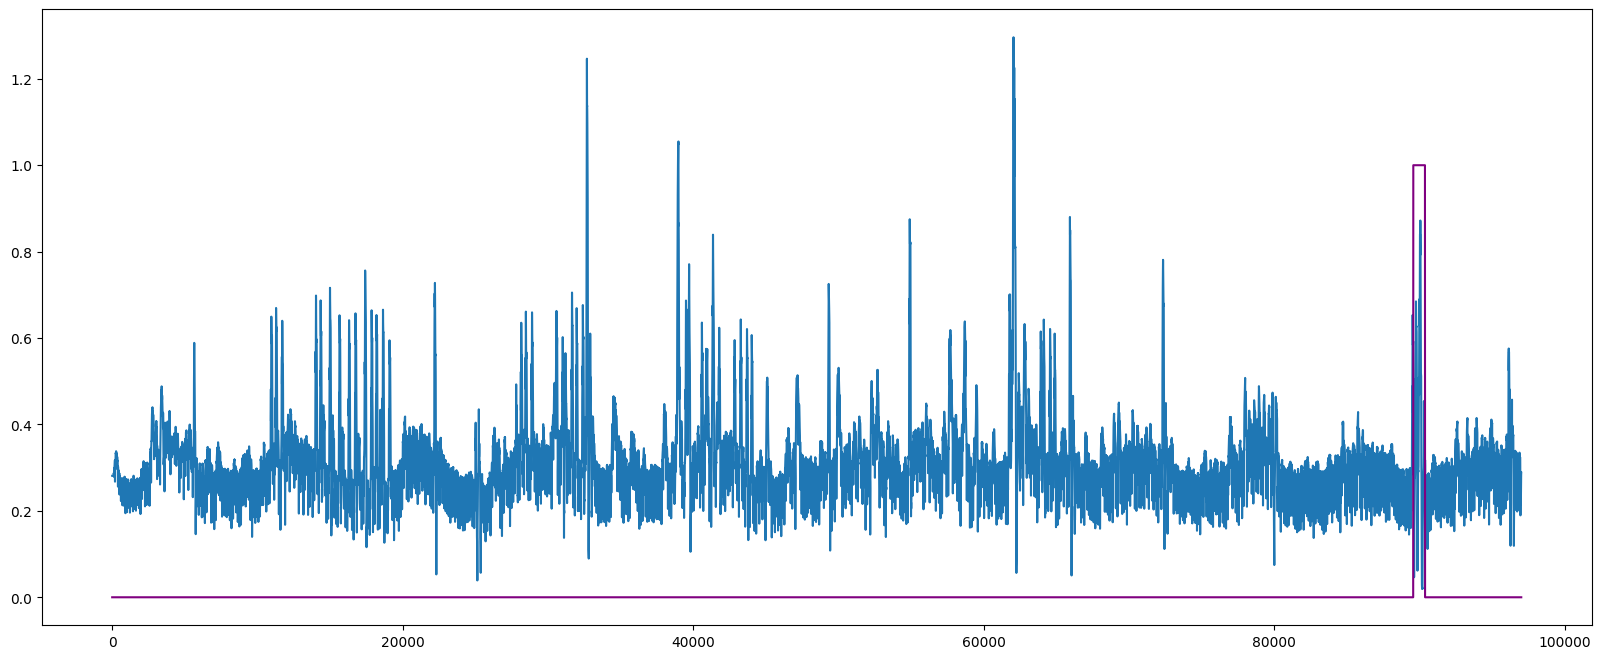

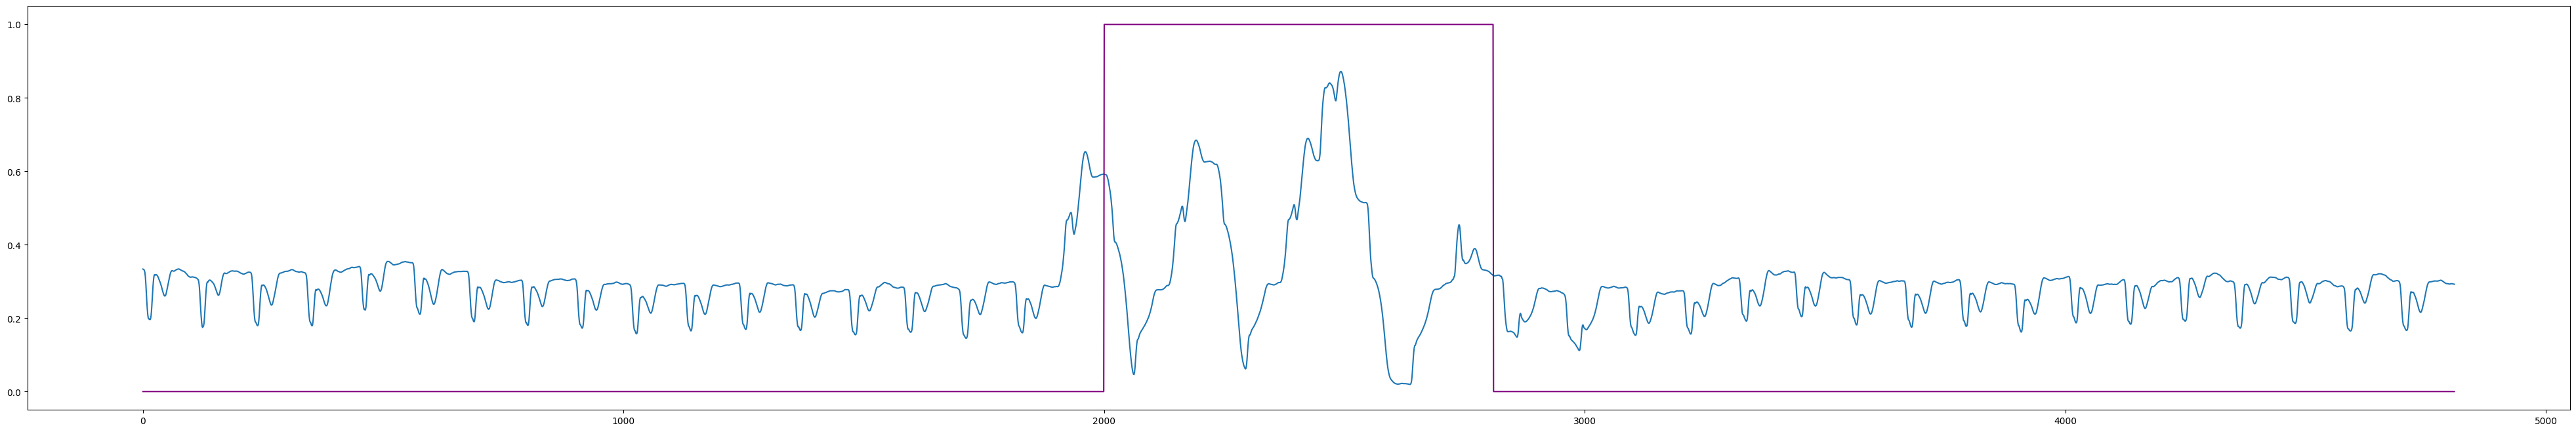

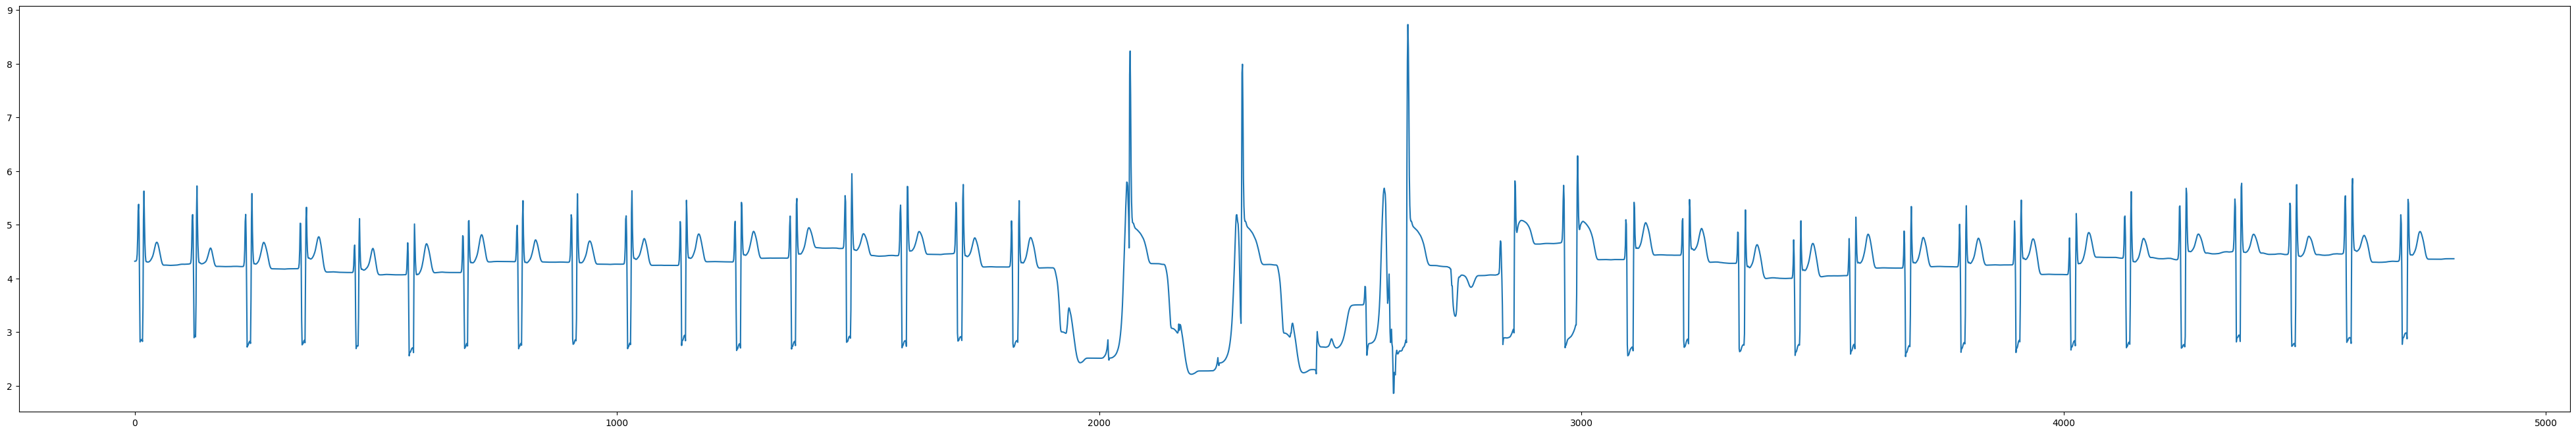

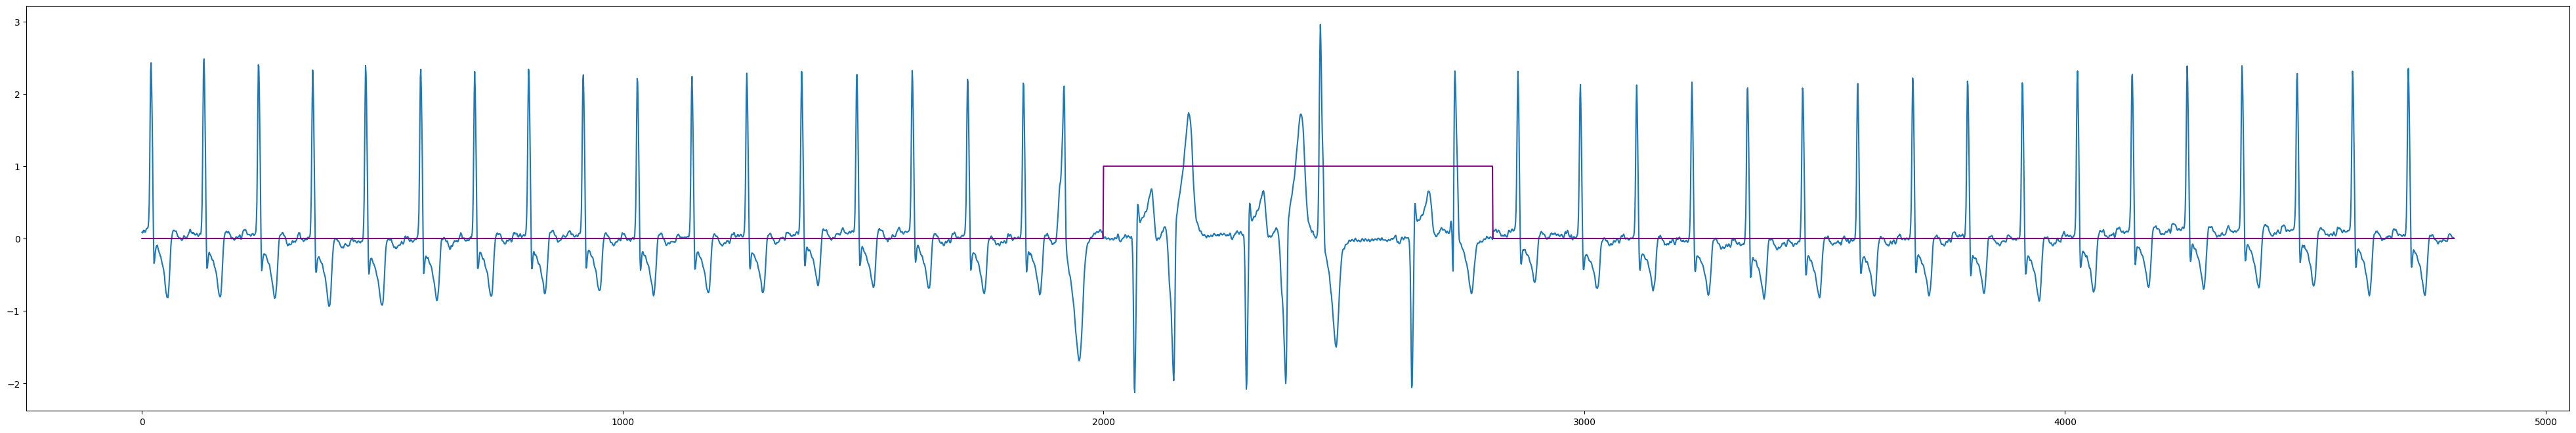

In [41]:
# 读取数据文件
data_file = '/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/237_UCR_Anomaly_mit14157longtermecg_19313_89560_90370.txt'
raw_data = np.loadtxt(data_file)
#异常区域
# 找到所有下划线的位置
underscore_indices = [i for i, char in enumerate(data_file) if char == '_']
# 找到最后一个点的位置
last_dot_index = data_file.rfind('.')
# 提取倒数第二个下划线后面的字符串
second_last_part = data_file[underscore_indices[-2] + 1:underscore_indices[-1]]
# 提取最后一个下划线之后的字符串
last_part = data_file[underscore_indices[-1] + 1:last_dot_index]
id=data_file[21:24]
a_start=int(second_last_part)
a_end=int(last_part)


plt.figure(figsize=(50,8))
plt.plot(raw_data)

# 设置窗口大小
window = 100

# 计算裕度指标
mos_data = cal_mos(raw_data, window)

# 使用原始数据的前 window 个数据进行补充
initial_mos_data = cal_mos(np.concatenate([raw_data[:window]] * 2), window)
mos_data = initial_mos_data + mos_data


flag=np.zeros(len(mos_data))
flag[a_start:a_end]=1
#创建 x 数据
x = np.linspace(0, len(mos_data), len(mos_data))  # x 从 0 到 mos_data 的长度
# 平移 x 数据
x_shifted = x + window
plt.figure(figsize=(20,8))
plt.plot(mos_data,label='MOS')
plt.plot(flag, label='Flag', color='purple')



mav_data = cal_mav(raw_data, window)
initial_mav_data = cal_mav(np.concatenate([raw_data[:window]] * 2), window)
mav_data = initial_mav_data + mav_data

plt.figure(figsize=(20,8))
plt.plot(mav_data,label='MAV')
plt.plot(flag, label='Flag', color='purple')


plt.figure(figsize=(50,8))
plt.plot(mav_data[a_start-2000:a_end+2000])
plt.plot(flag[a_start-2000:a_end+2000], label='Flag', color='purple')

plt.figure(figsize=(50,8))
plt.plot(mos_data[a_start-2000:a_end+2000])
plt.plot(flag[104630-2000:104890+2000], label='Flag', color='purple')

plt.figure(figsize=(50,8))
plt.plot(raw_data[a_start-2000:a_end+2000])
plt.plot(flag[a_start-2000:a_end+2000], label='Flag', color='purple')


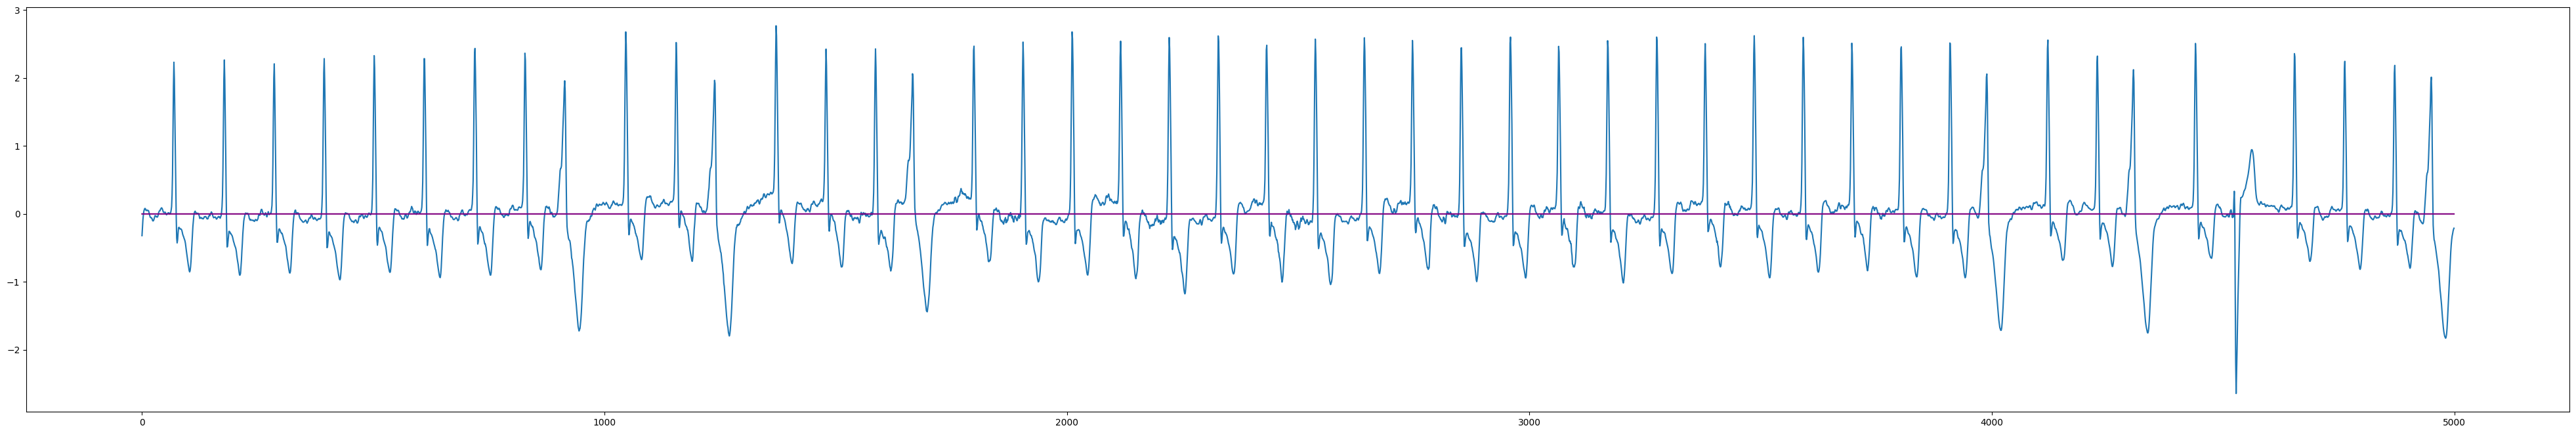

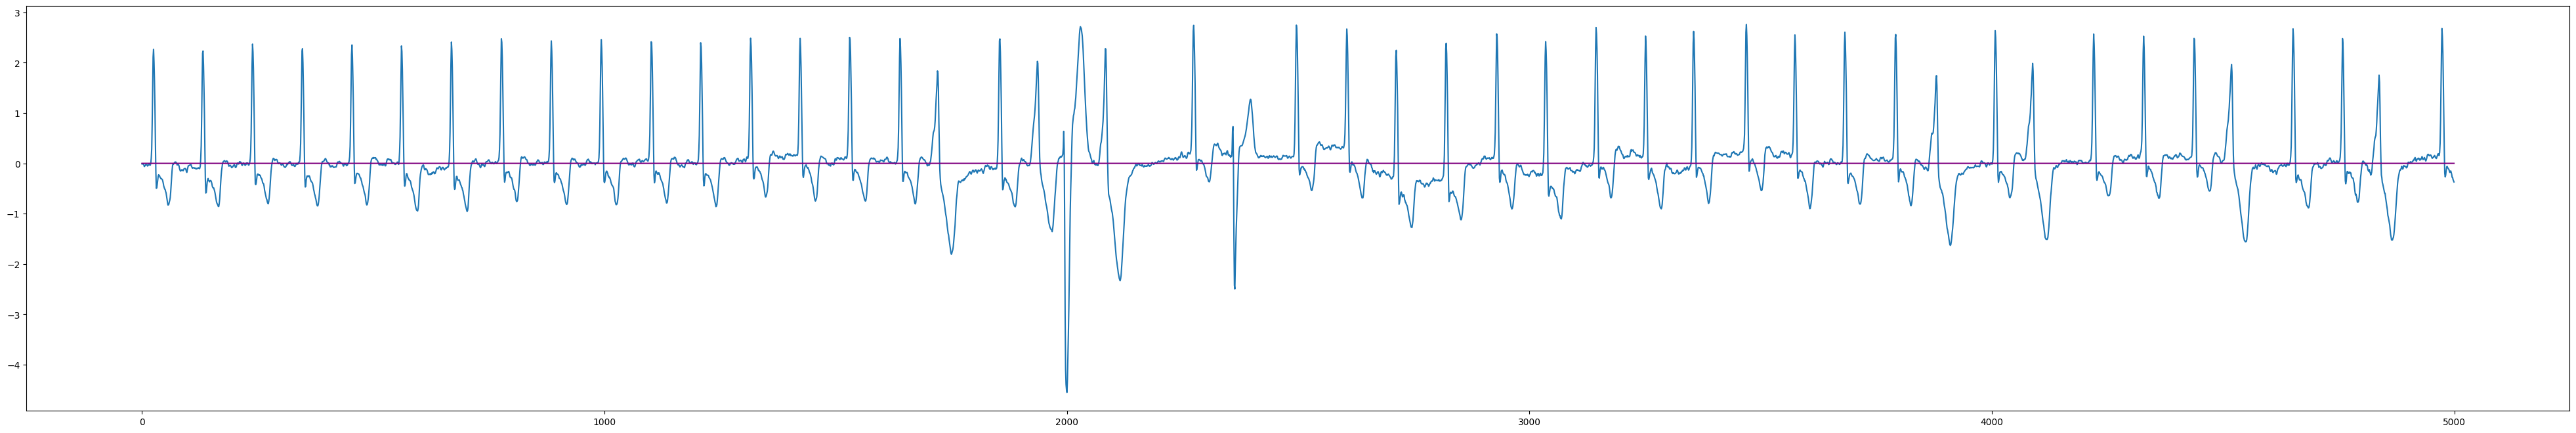

In [45]:
plt.figure(figsize=(50,8))
plt.plot(raw_data[10000:15000])
plt.plot(flag[10000:15000], label='Flag', color='purple')
plt.figure(figsize=(50,8))
plt.plot(raw_data[60000:65000])
plt.plot(flag[60000:65000], label='Flag', color='purple')

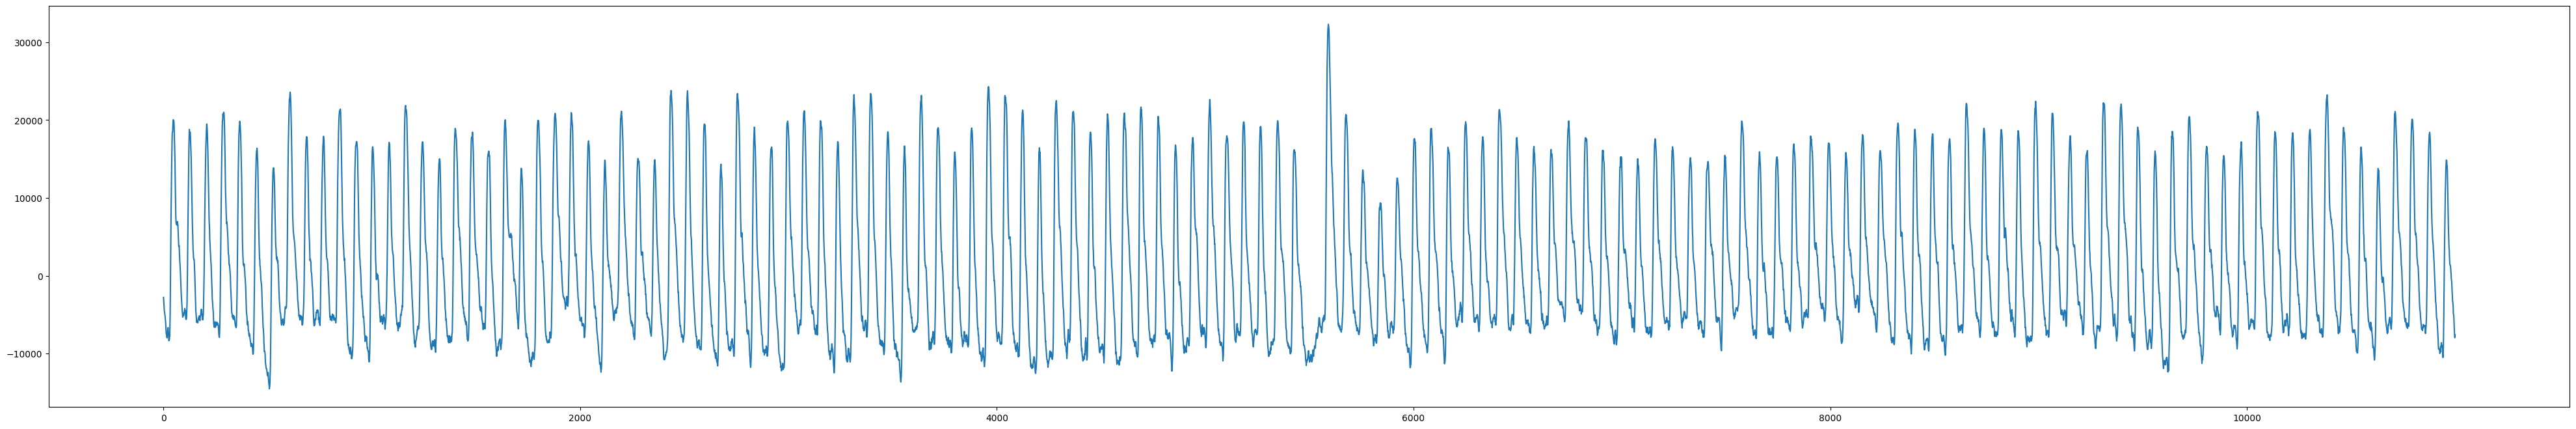

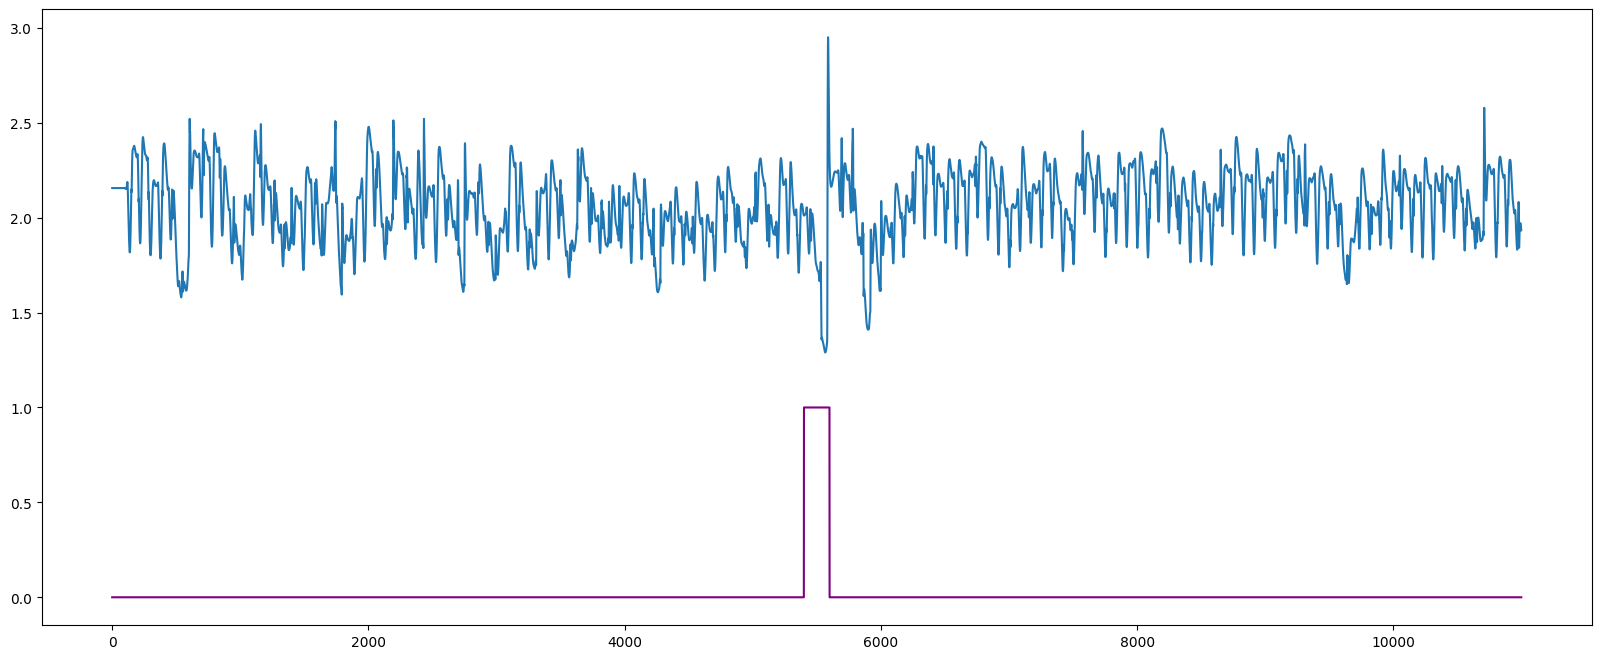

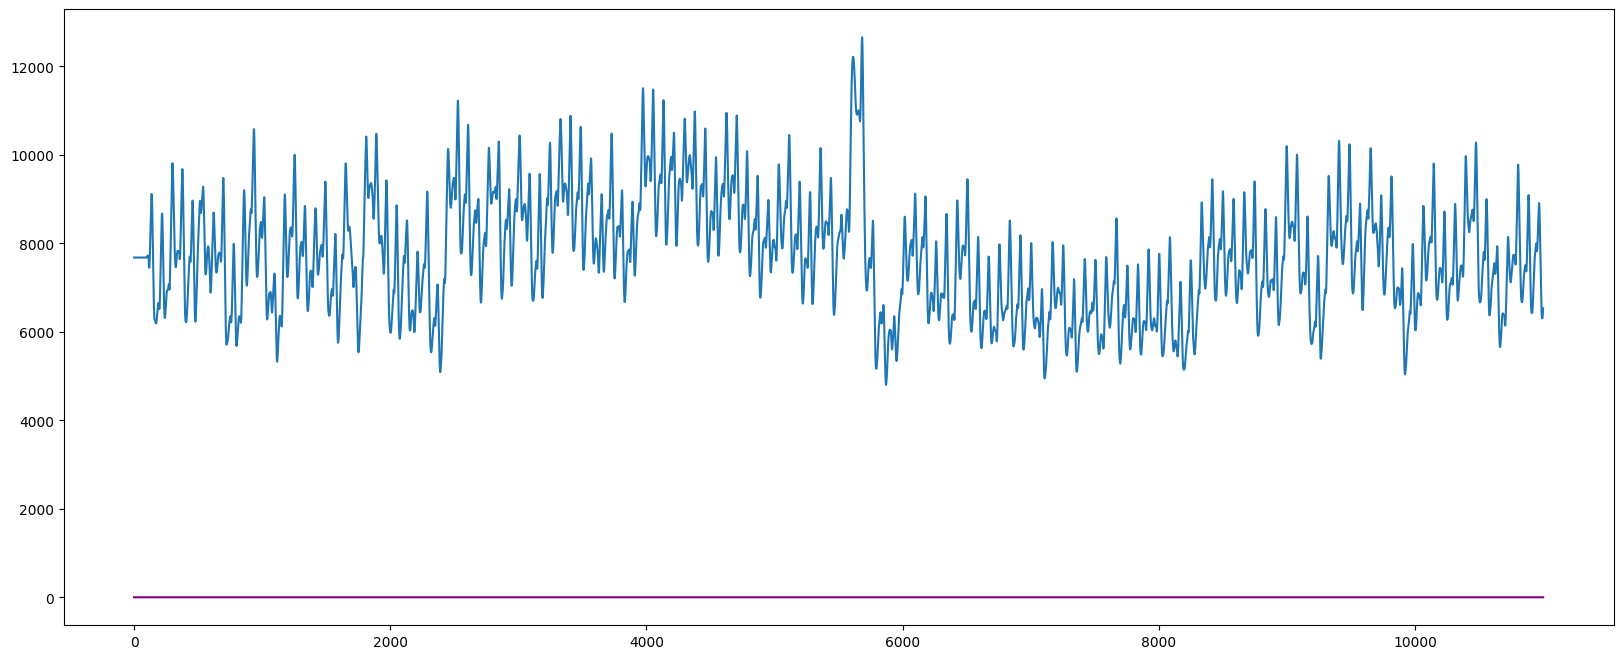

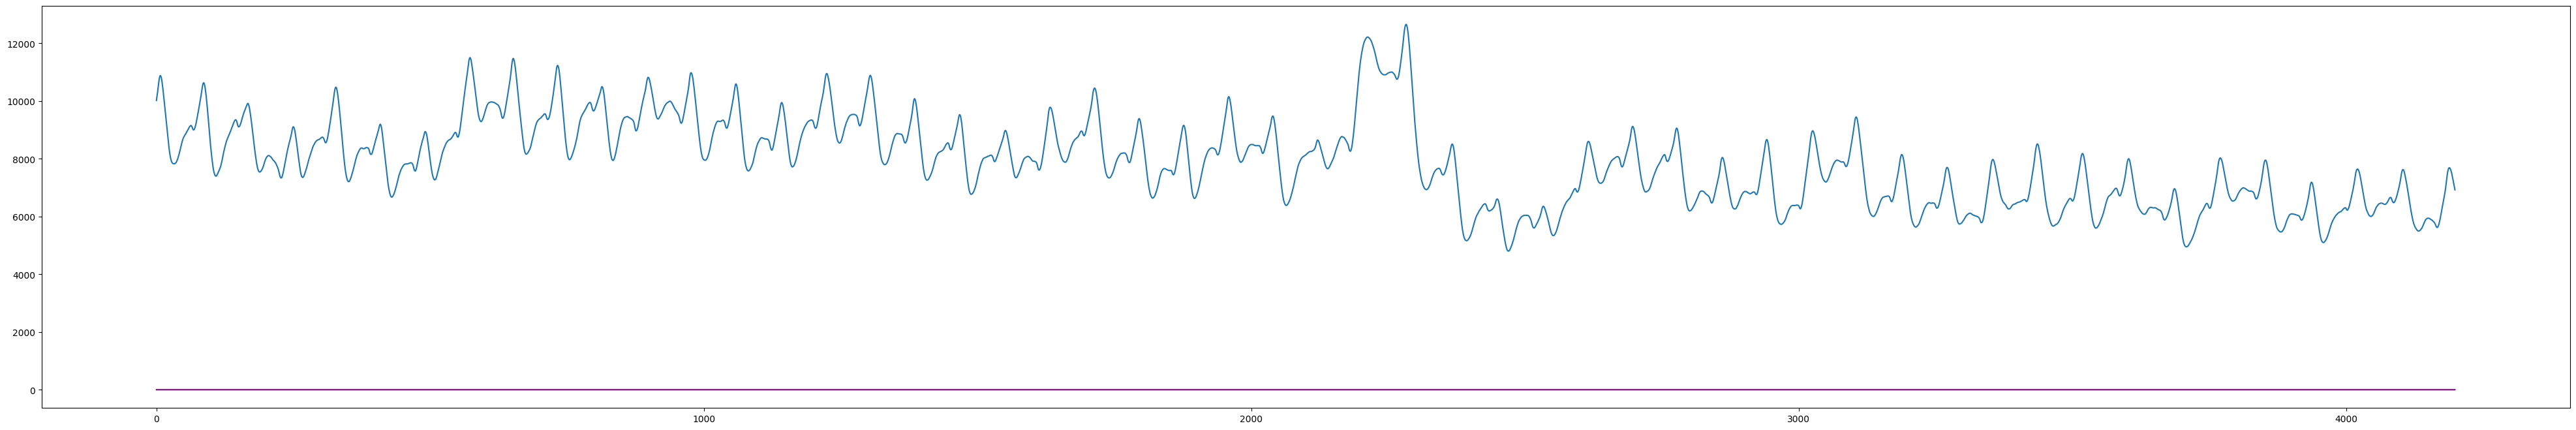

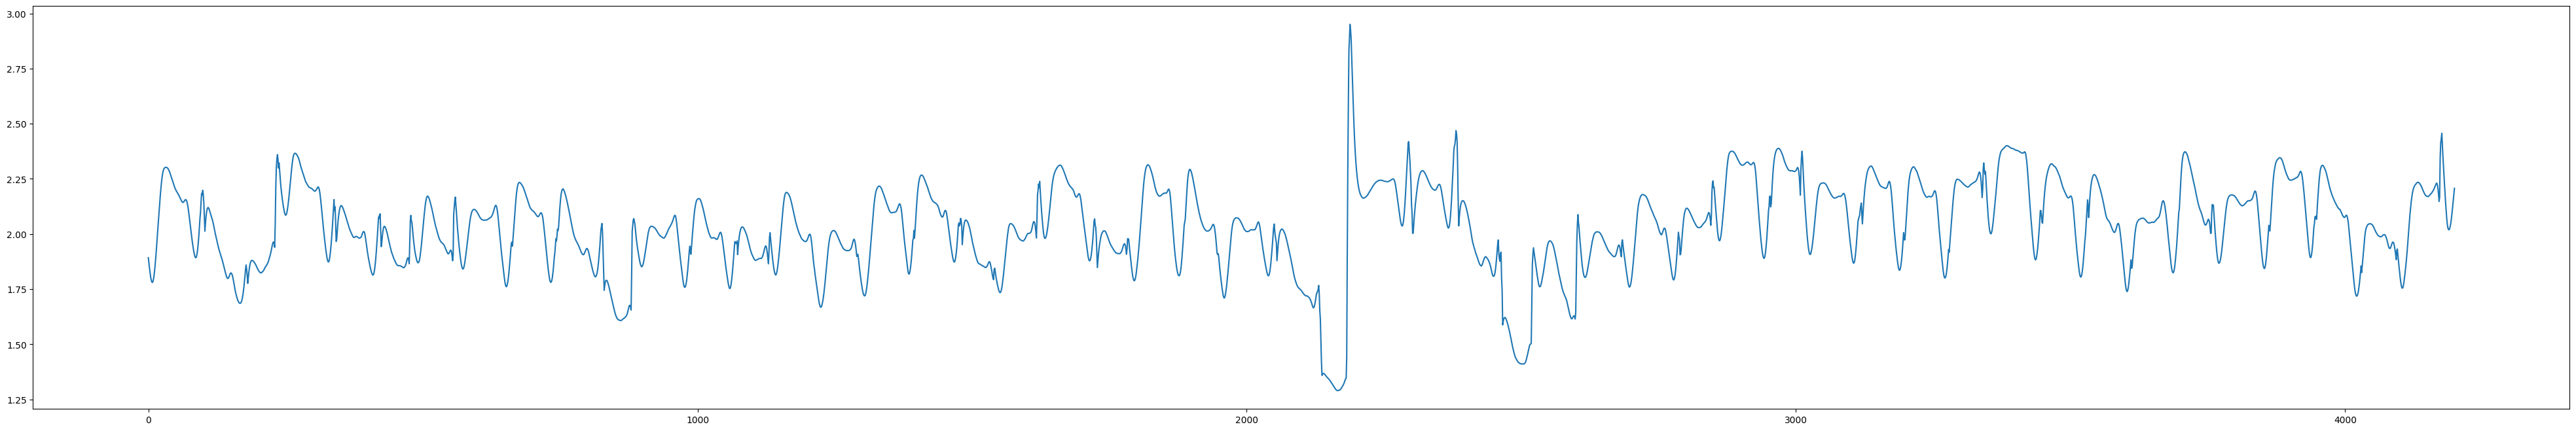

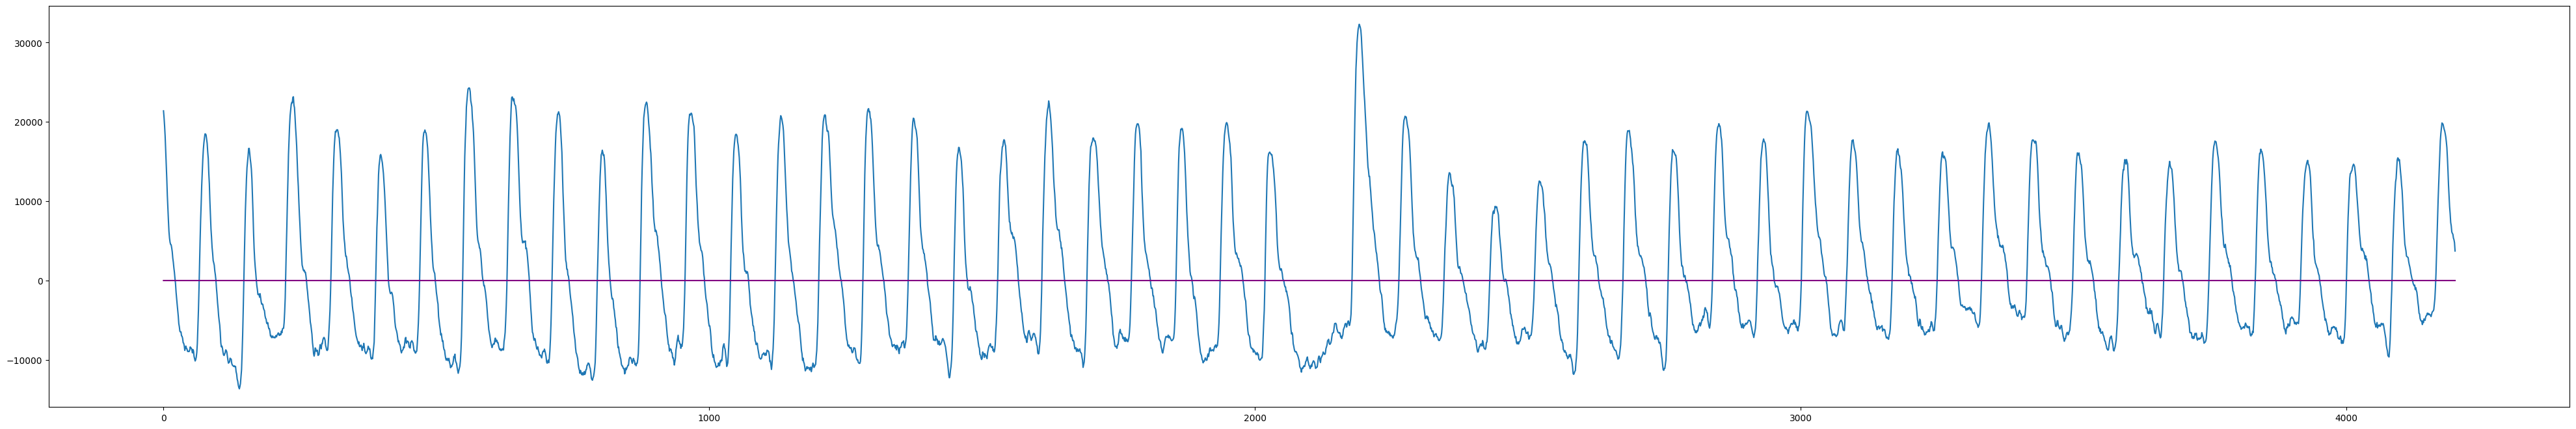

In [46]:
# 生成或导入你的时间序列数据
data_file = '/home/tslm-fzm/codes/Large-Time-Series-Model-main/dataset/UCR_Anomaly_FullData/004_UCR_Anomaly_DISTORTEDBIDMC1_2500_5400_5600.txt'
raw_data = np.loadtxt(data_file)
#异常区域
# 找到所有下划线的位置
underscore_indices = [i for i, char in enumerate(data_file) if char == '_']
# 找到最后一个点的位置
last_dot_index = data_file.rfind('.')
# 提取倒数第二个下划线后面的字符串
second_last_part = data_file[underscore_indices[-2] + 1:underscore_indices[-1]]
# 提取最后一个下划线之后的字符串
last_part = data_file[underscore_indices[-1] + 1:last_dot_index]
id=data_file[21:24]
a_start=int(second_last_part)
a_end=int(last_part)


plt.figure(figsize=(50,8))
plt.plot(raw_data)

# 设置窗口大小
window = 100

# 计算裕度指标
mos_data = cal_mos(raw_data, window)

# 使用原始数据的前 window 个数据进行补充
initial_mos_data = cal_mos(np.concatenate([raw_data[:window]] * 2), window)
mos_data = initial_mos_data + mos_data


flag=np.zeros(len(mos_data))
flag[a_start:a_end]=1
#创建 x 数据
x = np.linspace(0, len(mos_data), len(mos_data))  # x 从 0 到 mos_data 的长度
# 平移 x 数据
x_shifted = x + window
plt.figure(figsize=(20,8))
plt.plot(mos_data,label='MOS')
plt.plot(flag, label='Flag', color='purple')



mav_data = cal_mav(raw_data, window)
initial_mav_data = cal_mav(np.concatenate([raw_data[:window]] * 2), window)
mav_data = initial_mav_data + mav_data

plt.figure(figsize=(20,8))
plt.plot(mav_data,label='MAV')
plt.plot(flag, label='Flag', color='purple')


plt.figure(figsize=(50,8))
plt.plot(mav_data[a_start-2000:a_end+2000])
plt.plot(flag[a_start-2000:a_end+2000], label='Flag', color='purple')

plt.figure(figsize=(50,8))
plt.plot(mos_data[a_start-2000:a_end+2000])
plt.plot(flag[104630-2000:104890+2000], label='Flag', color='purple')

plt.figure(figsize=(50,8))
plt.plot(raw_data[a_start-2000:a_end+2000])
plt.plot(flag[a_start-2000:a_end+2000], label='Flag', color='purple')